In [2]:
!pip install dask-ml
from dask_ml import *

     |████████████████████████████████| 148 kB 5.1 MB/s            


In [3]:
!pip install hummingbird_ml
!pip install hummingbird_ml[extra]
!pip install dask
!pip install dask-cudf
!pip install dask_cuda

     |████████████████████████████████| 181 kB 5.3 MB/s            
     |████████████████████████████████| 83 kB 2.2 MB/s             
     |████████████████████████████████| 14.6 MB 60.9 MB/s            
     |████████████████████████████████| 304 kB 60.3 MB/s            
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.4
    Uninstalling protobuf-3.19.4:
      Successfully uninstalled protobuf-3.19.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
explainable-ai-sdk 1.3.2 requires xai-image-widget, which is not installed.
beatrix-jupyterlab 3.1.6 requires google-cloud-bigquery-storage, which is not installed.
tfx-bsl 1.5.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.15.0 which is incompatible.
tfx-bsl 1.5.0 requires numpy<1.20,>=

In [4]:
import sklearn
from sklearn.model_selection import GridSearchCV
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score, pairwise_distances, silhouette_samples, silhouette_score, confusion_matrix, roc_curve, auc
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering 

from statsmodels.stats.outliers_influence import variance_inflation_factor
from time import time
from datetime import datetime
import matplotlib.cm as cm
from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer
from datetime import datetime
from joblib import Parallel, delayed

import seaborn as sns
import plotly.express as px
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from hummingbird.ml import convert, load
import joblib

#Import libraries:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from dask.distributed import Client
# It's recommended to use dask_cuda for GPU assignment
from dask_cuda import LocalCUDACluster
from dask import array as da

%matplotlib inline

In [5]:
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import davies_bouldin_score, pairwise_distances, silhouette_samples, silhouette_score
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans, AgglomerativeClustering 
from sklearn.manifold import TSNE

# classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold

from statsmodels.stats.outliers_influence import variance_inflation_factor
from time import time
from datetime import datetime
import matplotlib.cm as cm
from scipy.spatial.distance import cdist
from yellowbrick.cluster import KElbowVisualizer
from datetime import datetime
from joblib import Parallel, delayed

import seaborn as sns
import plotly.express as px
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

In [6]:
X = pd.read_csv("/kaggle/input/logstdvif/x_vif_only.csv")
X.drop(['Unnamed: 0','rev_stop'], axis=1, inplace=True)
y = pd.read_csv("/kaggle/input/logstdvif/y.csv")
df=pd.concat([X,y],axis=1)
df.drop(['Unnamed: 0'], axis=1, inplace=True)

X = pd.read_csv("/kaggle/input/logstdvif/x_vif_only.csv")
X.drop(['Unnamed: 0','rev_stop'], axis=1, inplace=True)
y = pd.read_csv("/kaggle/input/logstdvif/y.csv", index_col=None)['went_on_backorder']

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No backorder', round(y.value_counts()[0]/len(y) * 100,2), '% of the dataset')
print('Backorder', round(y.value_counts()[1]/len(y) * 100,2), '% of the dataset')

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
# original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No backorder 99.3 % of the dataset
Backorder 0.7 % of the dataset
Train: [ 259572  259620  259654 ... 1775315 1775316 1775317] Test: [     0      1      2 ... 355895 355896 355897]
Train: [      0       1       2 ... 1775315 1775316 1775317] Test: [259572 259620 259654 ... 711229 711230 711231]
Train: [      0       1       2 ... 1775315 1775316 1775317] Test: [ 562975  562992  563216 ... 1066527 1066528 1066529]
Train: [      0       1       2 ... 1775315 1775316 1775317] Test: [ 913555  913679  913781 ... 1549977 1550291 1550807]
Train: [      0       1       2 ... 1549977 1550291 1550807] Test: [1420136 1420137 1420138 ... 1775315 1775316 1775317]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99296253 0.00703747]
[0.99296181 0.00703819]


In [7]:
print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))
print("Before UnderSampling, counts of label '1': {}".format(sum(original_ytrain == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(original_ytrain == 0)))

print("test, counts of label '1': {}".format(sum(original_ytest == 1)))
print("test, counts of label '0': {} \n".format(sum(original_ytest == 0)))

Length of X (train): 1420255 | Length of y (train): 1420255
Length of X (test): 355063 | Length of y (test): 355063
Before UnderSampling, counts of label '1': 9995
Before UnderSampling, counts of label '0': 1410260 

test, counts of label '1': 2499
test, counts of label '0': 352564 



In [8]:
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import train_test_split, RandomizedSearchCV

sm1 = NearMiss(sampling_strategy={0:500,1:500}) # 500:500
x_train_res, y_train_res = sm1.fit_resample(original_Xtrain, original_ytrain)
sm2 = NearMiss(sampling_strategy={0:200,1:67}) # 200:200
x_test, y_test = sm2.fit_resample(original_Xtest, original_ytest)

In [9]:
#x_test, y_test = original_Xtest, original_ytest

In [10]:
print('After Sampling, the shape of train_X: {}'.format(x_train_res.shape))
print('After Sampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After Sampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After Sampling, counts of label '0': {}".format(sum(y_train_res == 0)))

print('After Sampling, the shape of test_X: {}'.format(x_test.shape))
print('After Sampling, the shape of test_y: {} \n'.format(y_test.shape))

print("After Sampling, counts of label '1': {}".format(sum(y_test == 1)))
print("After Sampling, counts of label '0': {}".format(sum(y_test == 0)))

After Sampling, the shape of train_X: (1000, 14)
After Sampling, the shape of train_y: (1000,) 

After Sampling, counts of label '1': 500
After Sampling, counts of label '0': 500
After Sampling, the shape of test_X: (267, 14)
After Sampling, the shape of test_y: (267,) 

After Sampling, counts of label '1': 67
After Sampling, counts of label '0': 200


In [11]:
'''
X = pd.read_csv("../input/logstdvif/x_vif_only.csv")
X.drop(['Unnamed: 0','rev_stop'], axis=1, inplace=True)
y = pd.read_csv("../input/logstdvif/y.csv")['went_on_backorder']

### from sklearn import * 
from collections import Counter
x_train,x_test,y_train,y_test = sklearn.model_selection.train_test_split(X,y,test_size=0.2,random_state=0)   
# Check the number of records
print('The number of records in the training dataset is', x_train.shape[0])
print('The number of records in the test dataset is', x_test.shape[0])

print("Before OverSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label '0': {} \n".format(sum(y_train == 0)))
from imblearn.over_sampling import SMOTENC

oversample = SMOTENC(sampling_strategy={1: int(1410291/3)},categorical_features=[9,10,11,12,13], random_state = 2)
x_train_res, y_train_res = oversample.fit_resample(x_train, y_train)
print('After OverSampling, the shape of train_X: {}'.format(x_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))

print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))
'''

'\nX = pd.read_csv("../input/logstdvif/x_vif_only.csv")\nX.drop([\'Unnamed: 0\',\'rev_stop\'], axis=1, inplace=True)\ny = pd.read_csv("../input/logstdvif/y.csv")[\'went_on_backorder\']\n\n### from sklearn import * \nfrom collections import Counter\nx_train,x_test,y_train,y_test = sklearn.model_selection.train_test_split(X,y,test_size=0.2,random_state=0)   \n# Check the number of records\nprint(\'The number of records in the training dataset is\', x_train.shape[0])\nprint(\'The number of records in the test dataset is\', x_test.shape[0])\n\nprint("Before OverSampling, counts of label \'1\': {}".format(sum(y_train == 1)))\nprint("Before OverSampling, counts of label \'0\': {} \n".format(sum(y_train == 0)))\nfrom imblearn.over_sampling import SMOTENC\n\noversample = SMOTENC(sampling_strategy={1: int(1410291/3)},categorical_features=[9,10,11,12,13], random_state = 2)\nx_train_res, y_train_res = oversample.fit_resample(x_train, y_train)\nprint(\'After OverSampling, the shape of train_X: {}\

In [12]:
'''
pd.DataFrame(x_train_res).to_csv('x_train_res.csv')
pd.DataFrame(y_train_res).to_csv('y_train_res.csv')
pd.DataFrame(x_test).to_csv('x_test.csv')
pd.DataFrame(y_test).to_csv('y_test.csv')
'''

"\npd.DataFrame(x_train_res).to_csv('x_train_res.csv')\npd.DataFrame(y_train_res).to_csv('y_train_res.csv')\npd.DataFrame(x_test).to_csv('x_test.csv')\npd.DataFrame(y_test).to_csv('y_test.csv')\n"

In [13]:
'''
x_train_res=pd.read_csv('../input/smotencscmodelling/x_train_res.csv')
y_train_res=pd.read_csv('../input/smotencscmodelling/y_train_res.csv')
x_test=pd.read_csv('../input/smotencscmodelling/x_test.csv')
y_test=pd.read_csv('../input/smotencscmodelling/y_test.csv')
# dropping the Unnamed: 0 column
x_train_res = x_train_res.drop(['Unnamed: 0'],axis=1)
y_train_res = y_train_res.drop(['Unnamed: 0'],axis=1)['went_on_backorder']
x_test = x_test.drop(['Unnamed: 0'],axis=1)
y_test = y_test.drop(['Unnamed: 0'],axis=1)['went_on_backorder']
'''

"\nx_train_res=pd.read_csv('../input/smotencscmodelling/x_train_res.csv')\ny_train_res=pd.read_csv('../input/smotencscmodelling/y_train_res.csv')\nx_test=pd.read_csv('../input/smotencscmodelling/x_test.csv')\ny_test=pd.read_csv('../input/smotencscmodelling/y_test.csv')\n# dropping the Unnamed: 0 column\nx_train_res = x_train_res.drop(['Unnamed: 0'],axis=1)\ny_train_res = y_train_res.drop(['Unnamed: 0'],axis=1)['went_on_backorder']\nx_test = x_test.drop(['Unnamed: 0'],axis=1)\ny_test = y_test.drop(['Unnamed: 0'],axis=1)['went_on_backorder']\n"

# Adacost

In [112]:
import numpy as np
from sklearn.ensemble import AdaBoostClassifier


class AdaCostClassifier(AdaBoostClassifier): 
    def __init__(self, base_estimator=None, n_estimators=150, learning_rate=0.5, 
                 FNcost='auto', FPcost=1, algorithm='SAMME.R', random_state=None):
        super(AdaBoostClassifier, self).__init__(
            base_estimator=base_estimator,n_estimators=n_estimators,
            learning_rate=learning_rate, random_state=random_state)
        self.FPcost = FPcost
        self.FNcost = FNcost
        self.algorithm = algorithm
    
    def _boost_real(self, iboost, X, y, sample_weight, random_state):
        """Implement a single boost using the SAMME.R real algorithm."""
        estimator = self._make_estimator(random_state=random_state)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict_proba = estimator.predict_proba(X)

        if iboost == 0:
            self.classes_ = getattr(estimator, 'classes_', None)
            self.n_classes_ = len(self.classes_)
        y_predict = self.classes_.take(np.argmax(y_predict_proba, axis=1), axis=0)
        incorrect = y_predict != y
        estimator_error = np.mean(np.average(incorrect, weights=sample_weight, axis=0))
        if estimator_error <= 0:
            return sample_weight, 1., 0.

        n_classes = self.n_classes_
        classes = self.classes_
        y_codes = np.array([-1. / (n_classes - 1), 1.])
        y_coding = y_codes.take(classes == y[:, np.newaxis])
        proba = y_predict_proba  # alias for readability
        

        np.clip(proba, np.finfo(proba.dtype).eps, None, out=proba)
        
        estimator_weight = (-1. * self.learning_rate * ((n_classes - 1.) / n_classes)
                            * (y_coding * np.log(y_predict_proba)).sum(axis=1))
        
        if not iboost == self.n_estimators - 1:
            criteria = ((sample_weight > 0) | (estimator_weight < 0))
            sample_weight *= np.exp(estimator_weight * criteria * self._beta(y, y_predict))  
        return sample_weight, 1., estimator_error

    def _beta(self, y, y_hat):
        res = []
        ratio = sum(y==0) / sum(y==1)
        if self.FNcost == 'auto':
            self.FNcost = ratio
        
        for i in zip(y, y_hat):
            if  i[0] == 1 and i[1] == 0:
                res.append(self.FNcost)  
            elif i[0] == 0 and i[1] == 1:
                res.append(self.FPcost)    
            else:
                res.append(1)
        return np.array(res)

In [113]:
ratio = sum(y_train_res==0)/sum(y_train_res==1)

In [114]:
ratio

1.0

In [115]:
def modelfit(x_train, y_train, x_test, y_test, params, early_stopping_rounds=1000):    
    alg = AdaCostClassifier(learning_rate = 1, random_state=100)
    #cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True)
    grid_ada = sklearn.model_selection.GridSearchCV(estimator = alg, param_grid = params, cv=3, verbose=3, scoring='roc_auc', n_jobs = 1)
    
    #Fit the algorithm on the data
    grid_ada.fit(x_train, y_train)
    grid_ada = grid_ada
    grid_result = grid_ada.best_estimator_
    
    #train_history = grid_result.evals_result()
    y_pred_test = grid_result.predict(x_test)
    y_predprob_test = grid_result.predict_proba(x_test)[:,-1]
   
    #return grid_result, y_pred_train, y_predprob_train, y_pred_test, y_predprob_test, train_history
    return grid_ada, grid_result, y_pred_test, y_predprob_test
    
    print("Best Iteration: {}".format(grid_result.get_booster().best_iteration))
    
    feat_imp = pd.Series(grid_result.get_booster().get_score()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [116]:
#params={'FNcost':np.linspace(1.1, ratio, 3), 'FPcost':np.linspace(0.5, 1, 3)} #0.5

In [117]:
params={'learning_rate':[0.01,0.03,0.02,1],
        'FNcost':[1.5], 'FPcost':[1]} # [1.5, 2, 3]

In [118]:
cluster = LocalCUDACluster()
client = Client(cluster)
from joblib import parallel_backend

#client = Client(processes=False)   # create local cluster
#with joblib.parallel_backend('dask'):
with LocalCUDACluster() as cluster:
    with Client(cluster) as client:
        grid_ada, grid_result_ada, y_pred_test_ada, y_predprob_test_ada = modelfit(x_train_res, y_train_res, x_test, y_test, params)

distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.worker - WARNING - Mismatched versions found

+-------------+-------------+-----------+-----------+
| Package     | This Worker | scheduler | workers   |
+-------------+-------------+-----------+-----------+
| dask        | 2022.01.0   | 2022.02.0 | 2022.01.0 |
| distributed | 2022.01.0   | 2022.02.0 | 2022.01.0 |
+-------------+-------------+-----------+-----------+
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.worker - WARNING - Mismatched versions found

+-------------+-------------+-----------+-----------+
| Package     | This Worker | scheduler | workers   |
+-------------+-------------+-----------+-----------+
| dask        | 2022.01.0   | 2022.02.0 | 2022.01.0 |
| distributed | 2022.01.0   | 2022.02.0 | 2022.01.0 |
+-------------+-------------+-----------+-----------+
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distribu

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV 1/3] END FNcost=1.5, FPcost=1, learning_rate=0.01;, score=0.823 total time=  27.9s
[CV 2/3] END FNcost=1.5, FPcost=1, learning_rate=0.01;, score=0.856 total time=  27.4s
[CV 3/3] END FNcost=1.5, FPcost=1, learning_rate=0.01;, score=0.871 total time=  27.0s
[CV 1/3] END FNcost=1.5, FPcost=1, learning_rate=0.03;, score=0.870 total time=  23.3s
[CV 2/3] END FNcost=1.5, FPcost=1, learning_rate=0.03;, score=0.882 total time=  25.5s
[CV 3/3] END FNcost=1.5, FPcost=1, learning_rate=0.03;, score=0.899 total time=  26.4s
[CV 1/3] END FNcost=1.5, FPcost=1, learning_rate=0.02;, score=0.851 total time=  26.4s
[CV 2/3] END FNcost=1.5, FPcost=1, learning_rate=0.02;, score=0.873 total time=  26.4s
[CV 3/3] END FNcost=1.5, FPcost=1, learning_rate=0.02;, score=0.892 total time=  25.2s
[CV 1/3] END FNcost=1.5, FPcost=1, learning_rate=1;, score=0.898 total time=  24.8s
[CV 2/3] END FNcost=1.5, FPcost=1, learning_rate=1;, score=0.900 total ti

In [119]:
auc1 = roc_auc_score(y_test, y_predprob_test_ada)
f1_score1 = f1_score(y_test, y_pred_test_ada)
recall = recall_score(y_test, y_pred_test_ada)
acc = accuracy_score(y_test, y_pred_test_ada)
con_matrix = confusion_matrix(y_test, y_pred_test_ada)
print('AUC:{:.6f}, F1_score:{:.6f}, Recall:{:.6f}, Acc:{:.6f}'.format(auc1, f1_score1, recall, acc))
con_matrix

AUC:0.833918, F1_score:0.654321, Recall:0.791045, Acc:0.790262


array([[158,  42],
       [ 14,  53]])

In [120]:
print(sklearn.metrics.classification_report(y_test, y_pred_test_ada))

              precision    recall  f1-score   support

           0       0.92      0.79      0.85       200
           1       0.56      0.79      0.65        67

    accuracy                           0.79       267
   macro avg       0.74      0.79      0.75       267
weighted avg       0.83      0.79      0.80       267



In [121]:
grid_ada.best_params_, grid_ada.best_score_

({'FNcost': 1.5, 'FPcost': 1, 'learning_rate': 1}, 0.9075105326465603)

In [122]:
pd.DataFrame(grid_ada.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_FNcost,param_FPcost,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,25.213133,0.503533,2.248435,0.145886,1.5,1,0.01,"{'FNcost': 1.5, 'FPcost': 1, 'learning_rate': ...",0.822654,0.856378,0.871203,0.850078,0.020315,4
1,22.978046,1.078828,2.089639,0.254343,1.5,1,0.03,"{'FNcost': 1.5, 'FPcost': 1, 'learning_rate': ...",0.869949,0.881971,0.899250,0.883723,0.012026,2
2,23.961944,0.976213,2.059598,0.431658,1.5,1,0.02,"{'FNcost': 1.5, 'FPcost': 1, 'learning_rate': ...",0.851160,0.872502,0.892234,0.871965,0.016773,3
3,23.919607,0.820279,2.202745,0.149550,1.5,1,1,"{'FNcost': 1.5, 'FPcost': 1, 'learning_rate': 1}",0.898078,0.900224,0.924230,0.907511,0.011855,1


In [123]:
#https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred_test_ada))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.92      0.79      0.79      0.85      0.79      0.62       200
          1       0.56      0.79      0.79      0.65      0.79      0.62        67

avg / total       0.83      0.79      0.79      0.80      0.79      0.62       267



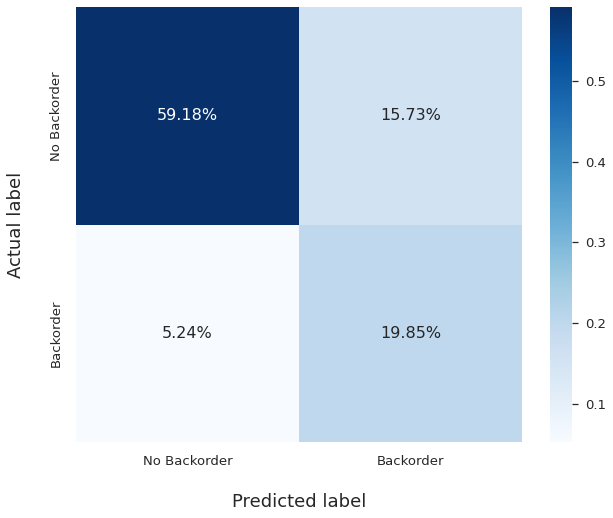

Text(0.5, 1.0, 'Precision-Recall curve:\nAverage Precision-Recall Score =0.77')

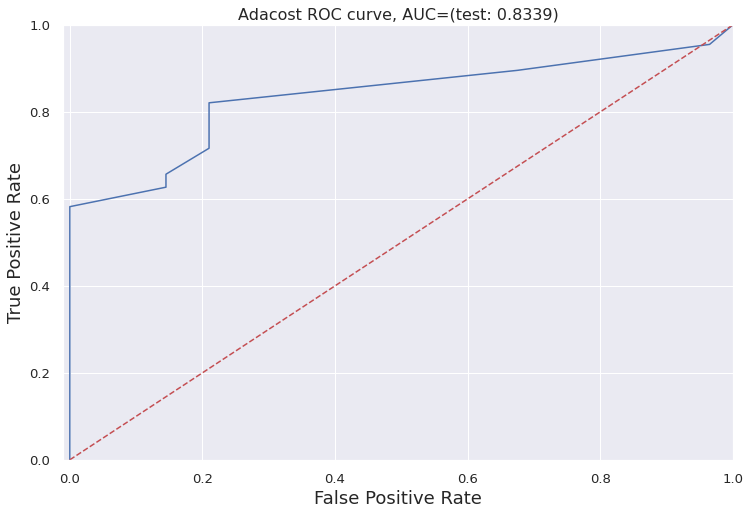

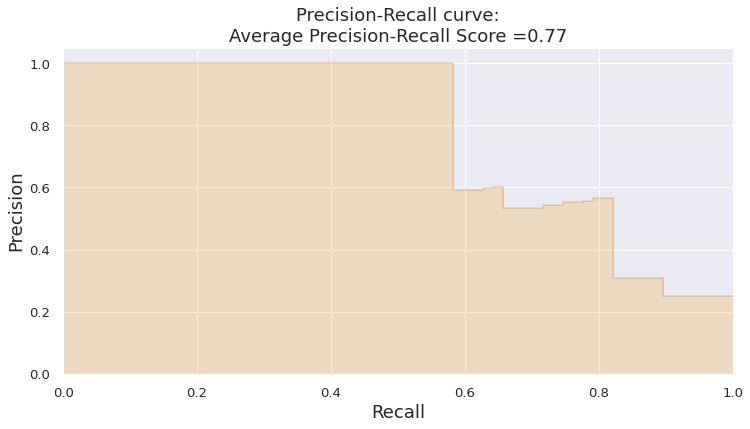

In [124]:
from sklearn.metrics import confusion_matrix

confusionMatrix = confusion_matrix(y_test,y_pred_test_ada,labels=[0,1])
cm_ada = confusion_matrix(y_test,y_pred_test_ada)
fig, ax = plt.subplots(figsize=(10,8))
sns.set(font_scale=1.2)
sns.heatmap(cm_ada/np.sum(cm_ada), fmt='.2%', annot=True, annot_kws={"size": 16}, cmap='Blues', cbar=True, xticklabels=['No Backorder','Backorder'], yticklabels=['No Backorder','Backorder'], ax=ax)
plt.grid(False)
plt.xlabel('\nPredicted label', fontsize=18)
plt.ylabel('Actual label\n', fontsize=18)
plt.savefig('ada_confusion_matrix.png')
plt.show()


fpr_ada, tpr_ada, _ = sklearn.metrics.roc_curve(y_test, y_predprob_test_ada)
auc_ada = sklearn.metrics.auc(fpr_ada, tpr_ada)
plt.figure(figsize=(12,8))
plt.title(f"Adacost ROC curve, AUC=(test: {auc_ada:.4f})", fontsize=16)
plt.plot(fpr_ada, tpr_ada, label="test data")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.axis([-0.01,1,0,1])
plt.savefig("ada_roc_auc.png")

fig = plt.figure(figsize=(12,6))
precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_predprob_test_ada)
plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')
plt.xlabel('Recall', fontsize=18)
plt.ylabel('Precision', fontsize=18)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve:\nAverage Precision-Recall Score ={0:0.2f}'.format(
          sklearn.metrics.average_precision_score(y_test, y_predprob_test_ada)), fontsize=18)

# CatBOOST

In [14]:
from sklearn.model_selection import RepeatedStratifiedKFold
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

def modelfit(x_train, y_train, x_test, y_test, params, client, early_stopping_rounds=100):    
    #evals_result = {}
    #eval_s = [(x_train, y_train), (x_test, y_test)]
    alg = CatBoostClassifier()
    #cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True)
    grid_cat = sklearn.model_selection.GridSearchCV(estimator = alg, param_grid = params, cv=3, verbose=2, scoring='roc_auc')
    
    #Fit the algorithm on the data
    #grid_xgb.fit(x_train, y_train, eval_set=eval_s, early_stopping_rounds=100)
    grid_cat.fit(x_train, y_train)
    grid_cat = grid_cat
    grid_result = grid_cat.best_estimator_
    
    #train_history = grid_result.evals_result()
    y_pred_test = grid_result.predict(x_test)
    y_predprob_test = grid_result.predict_proba(x_test)[:,1]
    
    #return grid_result, y_pred_train, y_predprob_train, y_pred_test, y_predprob_test, train_history
    return grid_cat, grid_result, y_pred_test, y_predprob_test    

In [15]:
params={'learning_rate': [0.5], 'early_stopping_rounds': [500],
             'task_type': ['GPU'], 'devices':['0:1'], 'boost_from_average': [False],
             'leaf_estimation_backtracking': ['AnyImprovement'],
              'grow_policy': ['Lossguide'], 
             'feature_border_type': ['GreedyLogSum'], 'border_count': [254], 
             'max_leaves': [100], 'score_function': ['Cosine'],
             'boosting_type':['Plain'],
             'sparse_features_conflict_fraction': [0], 'rsm': [1], 
             'posterior_sampling': [False], 'random_seed': [786], 
             'depth': [20], #4,6,20
             'random_strength': [1], 
             'loss_function': ['Logloss'], 'model_size_reg': [0.5],
             'eval_metric':['AUC'],
             'scale_pos_weight':[3]}#[3,1.5,2,1]
       

In [16]:
cluster = LocalCUDACluster()
client = Client(cluster)
from joblib import parallel_backend

#client = Client(processes=False)   # create local cluster
#with joblib.parallel_backend('dask'):
with LocalCUDACluster() as cluster:
    with Client(cluster) as client:
        grid_cat, grid_result_cat, y_pred_test_cat, y_predprob_test_cat = modelfit(x_train_res, y_train_res, x_test, y_test, params, client)

distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.worker - WARNING - Mismatched versions found

+-------------+-------------+-----------+-----------+
| Package     | This Worker | scheduler | workers   |
+-------------+-------------+-----------+-----------+
| dask        | 2022.01.0   | 2022.02.0 | 2022.01.0 |
| distributed | 2022.01.0   | 2022.02.0 | 2022.01.0 |
+-------------+-------------+-----------+-----------+
distributed.worker - WARNING - Mismatched versions found

+-------------+-------------+-----------+-----------+
| Package     | This Worker | scheduler | workers   |
+-------------+-------------+-----------+-----------+
| dask        | 2022.01.0   | 2022.02.0 | 2022.01.0 |
| distributed | 2022.01.0   | 2022.02.0 | 2022.01.0 |
+-------------+-------------+-----------+-----------+
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distribu

Fitting 3 folds for each of 1 candidates, totalling 3 fits
0:	learn: 0.9649379	total: 317ms	remaining: 5m 16s
1:	learn: 0.9712686	total: 631ms	remaining: 5m 14s
2:	learn: 0.9741002	total: 963ms	remaining: 5m 20s
3:	learn: 0.9751779	total: 1.35s	remaining: 5m 36s
4:	learn: 0.9752861	total: 1.7s	remaining: 5m 39s
5:	learn: 0.9754845	total: 2.07s	remaining: 5m 42s
6:	learn: 0.9754575	total: 2.44s	remaining: 5m 45s
7:	learn: 0.9755386	total: 2.85s	remaining: 5m 54s
8:	learn: 0.9755747	total: 3.36s	remaining: 6m 10s
9:	learn: 0.9756017	total: 3.91s	remaining: 6m 26s
10:	learn: 0.9756558	total: 4.45s	remaining: 6m 40s
11:	learn: 0.9756739	total: 5.12s	remaining: 7m 1s
12:	learn: 0.9756829	total: 5.5s	remaining: 6m 57s
13:	learn: 0.9756829	total: 5.82s	remaining: 6m 49s
14:	learn: 0.9756829	total: 6.12s	remaining: 6m 41s
15:	learn: 0.9756829	total: 6.44s	remaining: 6m 36s
16:	learn: 0.9756829	total: 6.82s	remaining: 6m 34s
17:	learn: 0.9756829	total: 7.13s	remaining: 6m 28s
18:	learn: 0.97569

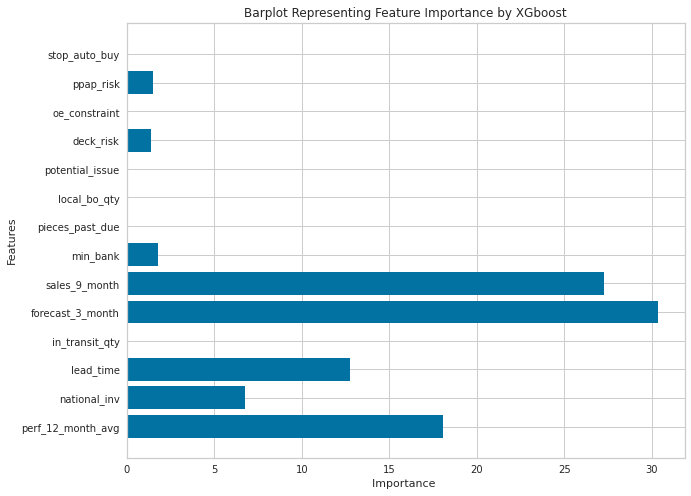

In [17]:
imp_feature = pd.DataFrame({'Feature': df.columns[:-1], 'Importance': grid_result_cat.feature_importances_})
plt.figure(figsize=(10,8))
plt.title("Barplot Representing Feature Importance by XGboost")
plt.xlabel("Importance ")
plt.ylabel("Features")
plt.barh(imp_feature['Feature'],imp_feature['Importance'])
plt.savefig("catboost_feature_imp.png", bbox_inches='tight')
plt.show()

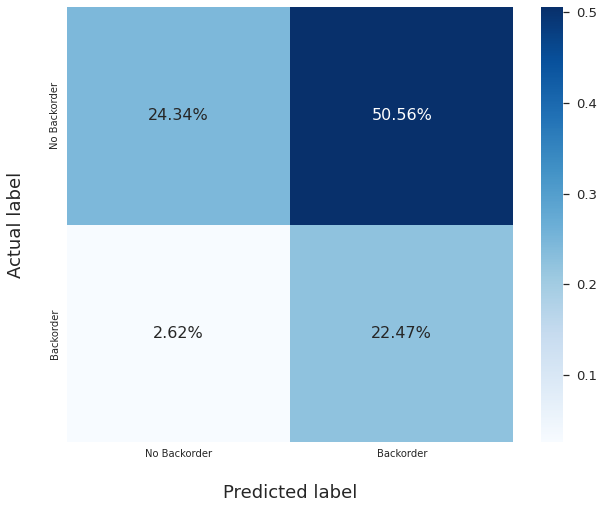

Text(0.5, 1.0, 'Precision-Recall curve:\nAverage Precision-Recall Score =0.68')

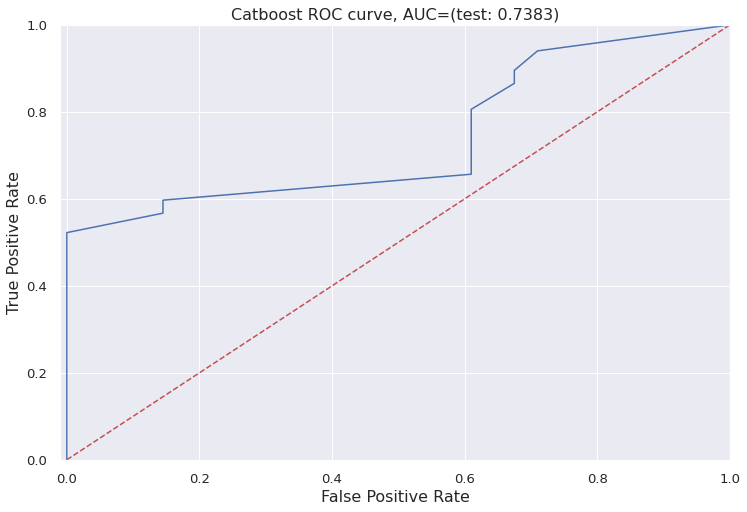

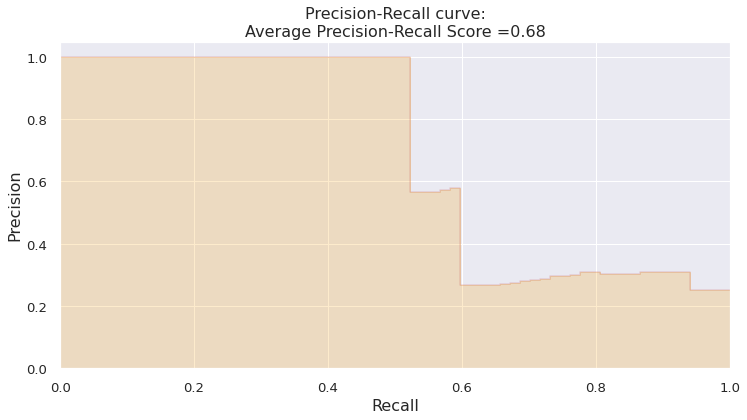

In [18]:
from sklearn.metrics import confusion_matrix

confusionMatrix = confusion_matrix(y_test,y_pred_test_cat,labels=[0,1])
cm_cat = confusion_matrix(y_test,y_pred_test_cat)
fig, ax = plt.subplots(figsize=(10,8))
sns.set(font_scale=1.2)
sns.heatmap(cm_cat/np.sum(cm_cat), fmt='.2%', annot=True, annot_kws={"size": 16}, cmap='Blues', cbar=True, xticklabels=['No Backorder','Backorder'], yticklabels=['No Backorder','Backorder'], ax=ax)
plt.grid(False)
plt.xlabel('\nPredicted label', fontsize=18)
plt.ylabel('Actual label\n', fontsize=18)
plt.savefig('cat_confusion_matrix.png')
plt.show()

fpr_cat, tpr_cat, _ = sklearn.metrics.roc_curve(y_test, y_predprob_test_cat)
auc_cat = sklearn.metrics.auc(fpr_cat, tpr_cat)
plt.figure(figsize=(12,8))
plt.title(f"Catboost ROC curve, AUC=(test: {auc_cat:.4f})", fontsize=16)
plt.plot(fpr_cat, tpr_cat, label="test data")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.axis([-0.01,1,0,1])
plt.savefig("cat_roc_auc.png")


fig = plt.figure(figsize=(12,6))
precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_predprob_test_cat)
plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve:\nAverage Precision-Recall Score ={0:0.2f}'.format(
          sklearn.metrics.average_precision_score(y_test, y_predprob_test_cat)), fontsize=16)

In [19]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred_test_cat))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.33      0.90      0.48      0.54      0.27       200
          1       0.31      0.90      0.33      0.46      0.54      0.31        67

avg / total       0.75      0.47      0.75      0.47      0.54      0.28       267



In [20]:
print(sklearn.metrics.classification_report(y_test, y_pred_test_cat))

              precision    recall  f1-score   support

           0       0.90      0.33      0.48       200
           1       0.31      0.90      0.46        67

    accuracy                           0.47       267
   macro avg       0.61      0.61      0.47       267
weighted avg       0.75      0.47      0.47       267



In [21]:
pd.DataFrame(grid_cat.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_boost_from_average,param_boosting_type,param_border_count,param_depth,param_devices,param_early_stopping_rounds,...,param_score_function,param_sparse_features_conflict_fraction,param_task_type,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,417.344752,19.459864,0.034355,0.00445,False,Plain,254,20,0:1,500,...,Cosine,0,GPU,"{'boost_from_average': False, 'boosting_type':...",0.823013,0.848045,0.87932,0.850126,0.023034,1


In [22]:
grid_cat.best_params_, grid_cat.best_score_

({'boost_from_average': False,
  'boosting_type': 'Plain',
  'border_count': 254,
  'depth': 20,
  'devices': '0:1',
  'early_stopping_rounds': 500,
  'eval_metric': 'AUC',
  'feature_border_type': 'GreedyLogSum',
  'grow_policy': 'Lossguide',
  'leaf_estimation_backtracking': 'AnyImprovement',
  'learning_rate': 0.5,
  'loss_function': 'Logloss',
  'max_leaves': 100,
  'model_size_reg': 0.5,
  'posterior_sampling': False,
  'random_seed': 786,
  'random_strength': 1,
  'rsm': 1,
  'scale_pos_weight': 3,
  'score_function': 'Cosine',
  'sparse_features_conflict_fraction': 0,
  'task_type': 'GPU'},
 0.850125735110833)

# LGBM

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb

def modelfit(x_train, y_train, x_test, y_test, params, client, early_stopping_rounds=100):    
    #evals_result = {}
    #eval_s = [(x_train, y_train), (x_test, y_test)]
    alg = lgb.LGBMClassifier()
    #cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True)
    grid_cat = sklearn.model_selection.GridSearchCV(estimator = alg, param_grid = params, cv=3, verbose=2, scoring='roc_auc')
    
    #Fit the algorithm on the data
    #grid_xgb.fit(x_train, y_train, eval_set=eval_s, early_stopping_rounds=100)
    grid_cat.fit(x_train, y_train)
    grid_cat = grid_cat
    grid_result = grid_cat.best_estimator_
    
    #train_history = grid_result.evals_result()
    y_pred_test = grid_result.predict(x_test)
    y_predprob_test = grid_result.predict_proba(x_test)[:,1]
    
    #return grid_result, y_pred_train, y_predprob_train, y_pred_test, y_predprob_test, train_history
    return grid_cat, grid_result, y_pred_test, y_predprob_test    

In [35]:
params={'n_estimators': [100, 200, 500],
                  'max_depth': [5, 10,30,40],
                  'learning_rate': [0.01, 0.1, 0.5],
                  'subsample': [0.8, 1.0],
                  'colsample_bytree': [0.8, 1.0]}
 
cluster = LocalCUDACluster()
client = Client(cluster)
from joblib import parallel_backend

#client = Client(processes=False)   # create local cluster
#with joblib.parallel_backend('dask'):
with LocalCUDACluster() as cluster:
    with Client(cluster) as client:
        grid_lgb, grid_result_lgb, y_pred_test_lgb, y_predprob_test_lgb = modelfit(x_train_res, y_train_res, x_test, y_test, params, client)

distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.worker - WARNING - Mismatched versions found

+-------------+-------------+-----------+-----------+
| Package     | This Worker | scheduler | workers   |
+-------------+-------------+-----------+-----------+
| dask        | 2022.01.0   | 2022.02.0 | 2022.01.0 |
| distributed | 2022.01.0   | 2022.02.0 | 2022.01.0 |
+-------------+-------------+-----------+-----------+
distributed.worker - WARNING - Mismatched versions found

+-------------+-------------+-----------+-----------+
| Package     | This Worker | scheduler | workers   |
+-------------+-------------+-----------+-----------+
| dask        | 2022.01.0   | 2022.02.0 | 2022.01.0 |
| distributed | 2022.01.0   | 2022.02.0 | 2022.01.0 |
+-------------+-------------+-----------+-----------+
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distribu

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8; total time=   0.1s
[CV] END 

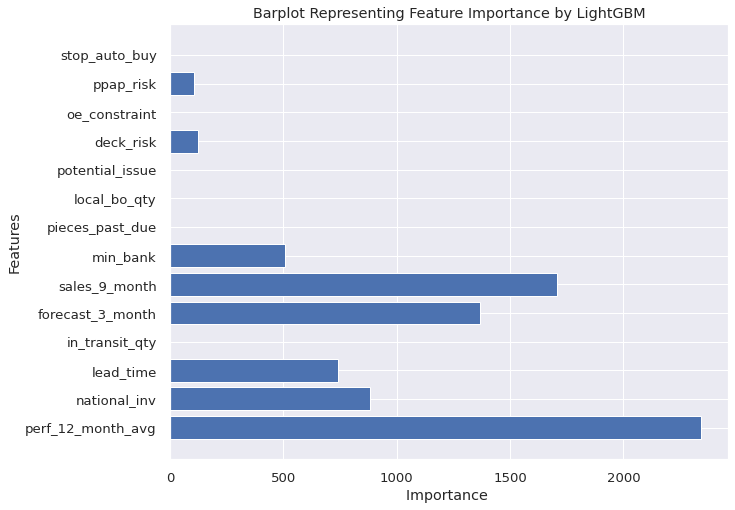

In [36]:
imp_feature = pd.DataFrame({'Feature': df.columns[:-1], 'Importance': grid_result_lgb.feature_importances_})
plt.figure(figsize=(10,8))
plt.title("Barplot Representing Feature Importance by LightGBM")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.barh(imp_feature['Feature'],imp_feature['Importance'])
plt.savefig("lgbm_feature_imp.png", bbox_inches='tight')
plt.show()

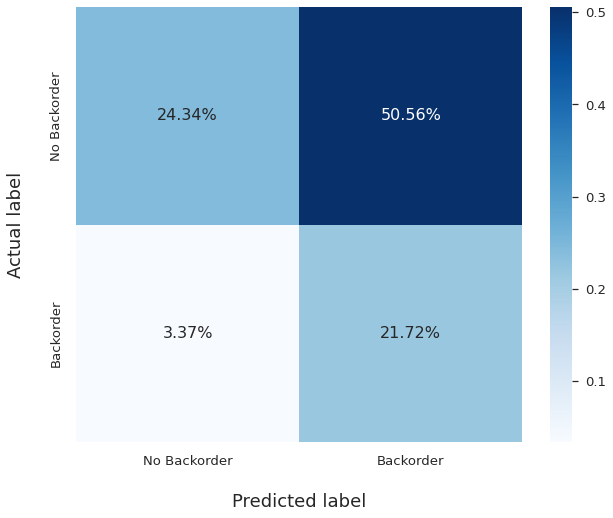

Text(0.5, 1.0, 'Precision-Recall curve:\nAverage Precision-Recall Score =0.69')

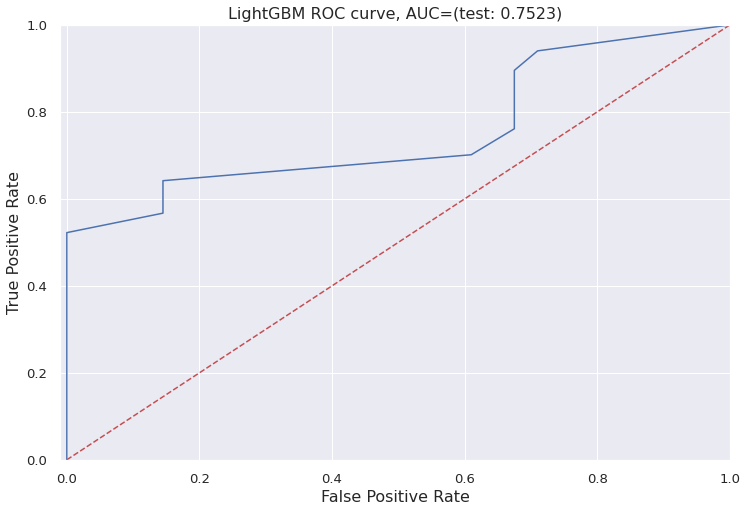

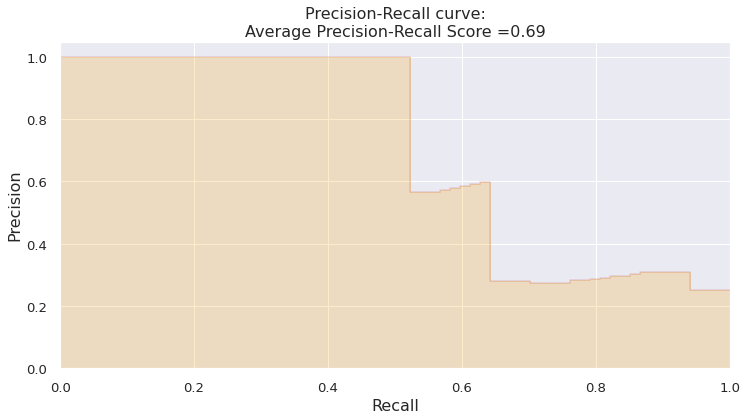

In [37]:
confusionMatrix = confusion_matrix(y_test,y_pred_test_lgb,labels=[0,1])
cm_lgb = confusion_matrix(y_test,y_pred_test_lgb)
fig, ax = plt.subplots(figsize=(10,8))
sns.set(font_scale=1.2)
sns.heatmap(cm_lgb/np.sum(cm_lgb), fmt='.2%', annot=True, annot_kws={"size": 16}, cmap='Blues', cbar=True, xticklabels=['No Backorder','Backorder'], yticklabels=['No Backorder','Backorder'], ax=ax)
plt.grid(False)
plt.xlabel('\nPredicted label', fontsize=18)
plt.ylabel('Actual label\n', fontsize=18)
plt.savefig('lgbm_confusion_matrix.png')
plt.show()

fpr_cat, tpr_cat, _ = sklearn.metrics.roc_curve(y_test, y_predprob_test_lgb)
auc_cat = sklearn.metrics.auc(fpr_cat, tpr_cat)
plt.figure(figsize=(12,8))
plt.title(f"LightGBM ROC curve, AUC=(test: {auc_cat:.4f})", fontsize=16)
plt.plot(fpr_cat, tpr_cat, label="test data")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.axis([-0.01,1,0,1])
plt.savefig("lgbm_roc_auc.png")


fig = plt.figure(figsize=(12,6))
precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_predprob_test_lgb)
plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve:\nAverage Precision-Recall Score ={0:0.2f}'.format(
          sklearn.metrics.average_precision_score(y_test, y_predprob_test_lgb)), fontsize=16)

In [38]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred_test_lgb))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.33      0.87      0.47      0.53      0.27       200
          1       0.30      0.87      0.33      0.45      0.53      0.30        67

avg / total       0.73      0.46      0.73      0.47      0.53      0.27       267



In [39]:
print(sklearn.metrics.classification_report(y_test, y_pred_test_lgb))

              precision    recall  f1-score   support

           0       0.88      0.33      0.47       200
           1       0.30      0.87      0.45        67

    accuracy                           0.46       267
   macro avg       0.59      0.60      0.46       267
weighted avg       0.73      0.46      0.47       267



In [40]:
pd.DataFrame(grid_lgb.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.071831,0.018957,0.004961,0.000685,0.8,0.01,5,100,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.903457,0.916294,0.922300,0.914017,0.007859,39
1,0.056329,0.002045,0.004439,0.000879,0.8,0.01,5,100,1.0,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.903457,0.916294,0.922300,0.914017,0.007859,39
2,0.096382,0.005220,0.006781,0.001111,0.8,0.01,5,200,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.907777,0.916276,0.926881,0.916978,0.007815,15
3,0.112329,0.004925,0.007621,0.001644,0.8,0.01,5,200,1.0,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.907777,0.916276,0.926881,0.916978,0.007815,15
4,0.270797,0.078653,0.014872,0.002210,0.8,0.01,5,500,0.8,"{'colsample_bytree': 0.8, 'learning_rate': 0.0...",0.910986,0.916979,0.925889,0.917952,0.006123,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,0.063859,0.004598,0.006021,0.000772,1.0,0.5,40,100,1.0,"{'colsample_bytree': 1.0, 'learning_rate': 0.5...",0.873642,0.897897,0.894975,0.888838,0.010811,101
140,0.123928,0.005497,0.009063,0.000469,1.0,0.5,40,200,0.8,"{'colsample_bytree': 1.0, 'learning_rate': 0.5...",0.852307,0.884045,0.890141,0.875498,0.016586,123
141,0.127114,0.008416,0.008817,0.001024,1.0,0.5,40,200,1.0,"{'colsample_bytree': 1.0, 'learning_rate': 0.5...",0.852307,0.884045,0.890141,0.875498,0.016586,123
142,0.415295,0.077181,0.019395,0.001837,1.0,0.5,40,500,0.8,"{'colsample_bytree': 1.0, 'learning_rate': 0.5...",0.839829,0.871095,0.883865,0.864930,0.018498,141


In [41]:
grid_lgb.best_params_, grid_lgb.best_score_

({'colsample_bytree': 1.0,
  'learning_rate': 0.01,
  'max_depth': 5,
  'n_estimators': 500,
  'subsample': 0.8},
 0.9195915578121586)

# Random Forest

In [42]:
from sklearn.ensemble import RandomForestClassifier

def modelfit(x_train, y_train, x_test, y_test, params, early_stopping_rounds=100):    
    alg = RandomForestClassifier(random_state=100)
    #cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True)
    grid_rf = sklearn.model_selection.GridSearchCV(estimator = alg, param_grid = params, cv=3, verbose=3, scoring='roc_auc', n_jobs = 1)
    
    #Fit the algorithm on the data
    grid_rf.fit(x_train, y_train)
    grid_rf = grid_rf
    grid_result = grid_rf.best_estimator_
    rf_model = convert(grid_result, 'pytorch')
    rf_model.to('cuda')
    y_pred_test = rf_model.predict(x_test)
    y_predprob_test = rf_model.predict_proba(x_test)[:,-1]
   
    #return grid_result, y_pred_train, y_predprob_train, y_pred_test, y_predprob_test, train_history
    return grid_rf, rf_model, y_pred_test, y_predprob_test
    
    #print("Best Iteration: {}".format(grid_result.get_booster().best_iteration))
    
    #feat_imp = pd.Series(grid_result.get_booster().get_score()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')

In [43]:
# Number of trees in random forest
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
n_estimators = [200]
# Number of features to consider at every split
max_features = ['auto']
# Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth = [30]
# Minimum number of samples required to split a node
#min_samples_split = [2, 5, 10]
min_samples_split = [2]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               "criterion": ['gini'],
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200], 'max_features': ['auto'], 'max_depth': [30], 'criterion': ['gini'], 'min_samples_split': [2], 'min_samples_leaf': [2], 'bootstrap': [True]}


In [44]:
cluster = LocalCUDACluster()
client = Client(cluster)
from joblib import parallel_backend

with LocalCUDACluster() as cluster:
    with Client(cluster) as client:
        grid_rf, grid_result_rf, y_pred_test_rf, y_predprob_test_rf = modelfit(x_train_res, y_train_res, x_test, y_test, random_grid)

distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.worker - WARNING - Mismatched versions found

+-------------+-------------+-----------+-----------+
| Package     | This Worker | scheduler | workers   |
+-------------+-------------+-----------+-----------+
| dask        | 2022.01.0   | 2022.02.0 | 2022.01.0 |
| distributed | 2022.01.0   | 2022.02.0 | 2022.01.0 |
+-------------+-------------+-----------+-----------+
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.worker - WARNING - Mismatched versions found

+-------------+-------------+-----------+-----------+
| Package     | This Worker | scheduler | workers   |
+-------------+-------------+-----------+-----------+
| dask        | 2022.01.0   | 2022.02.0 | 2022.01.0 |
| distributed | 2022.01.0   | 2022.02.0 | 2022.01.0 |
+-------------+-------------+-----------+-----------+
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distribu

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END bootstrap=True, criterion=gini, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.915 total time=   0.9s
[CV 2/3] END bootstrap=True, criterion=gini, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.918 total time=   0.9s
[CV 3/3] END bootstrap=True, criterion=gini, max_depth=30, max_features=auto, min_samples_leaf=2, min_samples_split=2, n_estimators=200;, score=0.922 total time=   0.9s


In [45]:
auc1 = roc_auc_score(y_test, y_predprob_test_rf)
f1_score1 = f1_score(y_test, y_pred_test_rf)
recall = recall_score(y_test, y_pred_test_rf)
acc = accuracy_score(y_test, y_pred_test_rf)
con_matrix = confusion_matrix(y_test, y_pred_test_rf)
cm_rf = confusion_matrix(y_test,y_pred_test_rf)
print('AUC:{:.6f}, F1_score:{:.6f}, Recall:{:.6f}, Acc:{:.6f}'.format(auc1, f1_score1, recall, acc))
con_matrix

AUC:0.739627, F1_score:0.446154, Recall:0.865672, Acc:0.460674


array([[ 65, 135],
       [  9,  58]])

In [46]:
print(sklearn.metrics.classification_report(y_test, y_pred_test_rf))

              precision    recall  f1-score   support

           0       0.88      0.33      0.47       200
           1       0.30      0.87      0.45        67

    accuracy                           0.46       267
   macro avg       0.59      0.60      0.46       267
weighted avg       0.73      0.46      0.47       267



In [49]:
#https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred_test_rf))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.33      0.87      0.47      0.53      0.27       200
          1       0.30      0.87      0.33      0.45      0.53      0.30        67

avg / total       0.73      0.46      0.73      0.47      0.53      0.27       267



In [47]:
grid_rf.best_params_, grid_rf.best_score_

({'bootstrap': True,
  'criterion': 'gini',
  'max_depth': 30,
  'max_features': 'auto',
  'min_samples_leaf': 2,
  'min_samples_split': 2,
  'n_estimators': 200},
 0.9184066035737485)

In [48]:
pd.DataFrame(grid_rf.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.809546,0.030676,0.087692,0.018446,True,gini,30,auto,2,2,200,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.914949,0.917881,0.92239,0.918407,0.003061,1


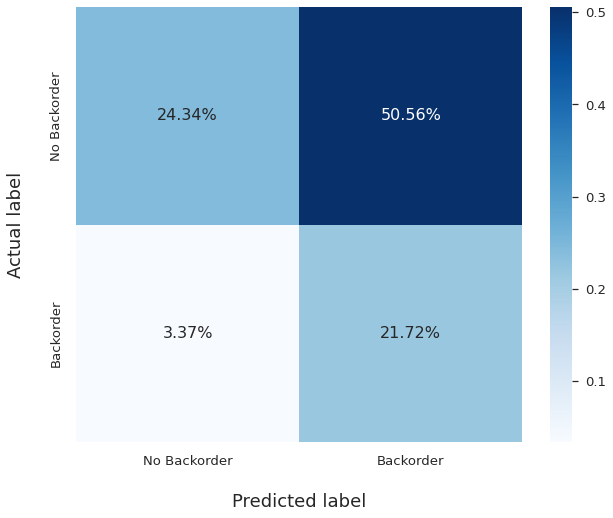

                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.33      0.87      0.47      0.53      0.27       200
          1       0.30      0.87      0.33      0.45      0.53      0.30        67

avg / total       0.73      0.46      0.73      0.47      0.53      0.27       267



Text(0.5, 1.0, 'Precision-Recall curve:\nAverage Precision-Recall Score =0.68')

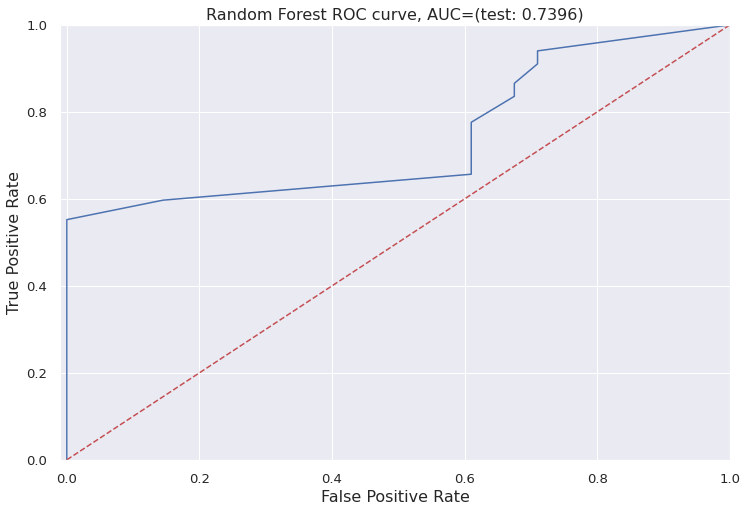

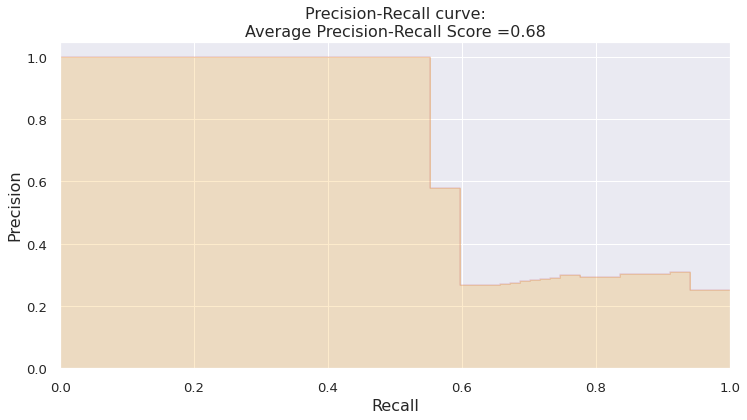

In [50]:
from sklearn.metrics import confusion_matrix

confusionMatrix = confusion_matrix(y_test,y_pred_test_rf,labels=[0,1])
cm_rf = confusion_matrix(y_test,y_pred_test_rf)
fig, ax = plt.subplots(figsize=(10,8))
sns.set(font_scale=1.2)
sns.heatmap(cm_rf/np.sum(cm_rf), fmt='.2%', annot=True, annot_kws={"size": 16}, cmap='Blues', cbar=True, xticklabels=['No Backorder','Backorder'], yticklabels=['No Backorder','Backorder'], ax=ax)
plt.grid(False)
plt.xlabel('\nPredicted label', fontsize=18)
plt.ylabel('Actual label\n', fontsize=18)
plt.savefig('rf_confusion_matrix.png')
plt.show()

fpr_rf, tpr_rf, _ = sklearn.metrics.roc_curve(y_test, y_predprob_test_rf)
auc_rf = sklearn.metrics.auc(fpr_rf, tpr_rf)
plt.figure(figsize=(12,8))
plt.title(f"Random Forest ROC curve, AUC=(test: {auc_rf:.4f})", fontsize=16)
plt.plot(fpr_rf, tpr_rf, label="test data")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.axis([-0.01,1,0,1])
plt.savefig("rf_roc_auc.png")

from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred_test_rf))

fig = plt.figure(figsize=(12,6))
precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_predprob_test_rf)
plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve:\nAverage Precision-Recall Score ={0:0.2f}'.format(
          sklearn.metrics.average_precision_score(y_test, y_predprob_test_cat)), fontsize=16)

# XGBOOST

In [54]:
from sklearn.model_selection import RepeatedStratifiedKFold
import xgboost as xgb
from xgboost.dask import DaskDMatrix

def modelfit(x_train, y_train, x_test, y_test, params, client: Client, early_stopping_rounds=100):    
    evals_result = {}
    eval_s = [(x_train, y_train), (x_test, y_test)]
    alg = xgb.XGBClassifier(tree_method = 'gpu_hist',
            use_label_encoder=False,
            n_estimators=1000,    
            nthread=4,
            gamma=0,
            eval_metric='auc',
            objective='binary:logistic',
            seed=27)
    #cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True)
    grid_xgb = sklearn.model_selection.GridSearchCV(estimator = alg, param_grid = params, cv=3, verbose=2, scoring='roc_auc')
    
    #Fit the algorithm on the data
    #grid_xgb.fit(x_train, y_train, eval_set=eval_s, early_stopping_rounds=100)
    grid_xgb.fit(x_train, y_train)
    grid_xgb = grid_xgb
    grid_result = grid_xgb.best_estimator_
    
    #train_history = grid_result.evals_result()
    y_pred_test = grid_result.predict(x_test)
    y_predprob_test = grid_result.predict_proba(x_test)[:,-1]
    
    print ("ROC_AUC Score (Test): %f" % metrics.roc_auc_score(y_test, y_predprob_test))
    
    print("Best Iteration: {}".format(grid_result.get_booster().best_iteration))
    
    feat_imp = pd.Series(grid_result.get_booster().get_score()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')   
    
    #return grid_result, y_pred_train, y_predprob_train, y_pred_test, y_predprob_test, train_history
    return grid_xgb, grid_result, y_pred_test, y_predprob_test
    

#'learning_rate':[0.05,0.1,0.2,0.3,1],#ideal: 0.01-0.2  #0.05\
#'max_depth':[i for i in range(6,10,2)], #might increase\
#'min_child_weight':[i for i in range(2,10,2)], # got 5 from GridSearch\
#'gamma':[i/10.0 for i in range(0,10,2)],         #  [7.667640921339915],\
#'subsample':[i/10.0 for i in range(4,10,2)],\
#'colsample_bytree':[i/10.0 for i in range(4,10,2)],\
#'scale_pos_weight':[3, 10, 50, 100],

distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.worker - WARNING - Mismatched versions found

+-------------+-------------+-----------+-----------+
| Package     | This Worker | scheduler | workers   |
+-------------+-------------+-----------+-----------+
| dask        | 2022.01.0   | 2022.02.0 | 2022.01.0 |
| distributed | 2022.01.0   | 2022.02.0 | 2022.01.0 |
+-------------+-------------+-----------+-----------+
distributed.worker - WARNING - Mismatched versions found

+-------------+-------------+-----------+-----------+
| Package     | This Worker | scheduler | workers   |
+-------------+-------------+-----------+-----------+
| dask        | 2022.01.0   | 2022.02.0 | 2022.01.0 |
| distributed | 2022.01.0   | 2022.02.0 | 2022.01.0 |
+-------------+-------------+-----------+-----------+
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distribu

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=20, min_child_weight=2, n_estimators=1000, scale_pos_weight=0.5; total time=  11.9s
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=20, min_child_weight=2, n_estimators=1000, scale_pos_weight=0.5; total time=   8.6s
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=20, min_child_weight=2, n_estimators=1000, scale_pos_weight=0.5; total time=   7.8s
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=20, min_child_weight=2, n_estimators=1000, scale_pos_weight=1; total time=   7.5s
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=20, min_child_weight=2, n_estimators=1000, scale_pos_weight=1; total time=  10.5s
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=20, min_child_weight=2, n_estimators=1000, scale_pos_weight=1; total time=   9.6s
[CV] END colsample_bytree=1, learning_rate=0.3, max_depth=20, min_child_weight=2, n_estimators

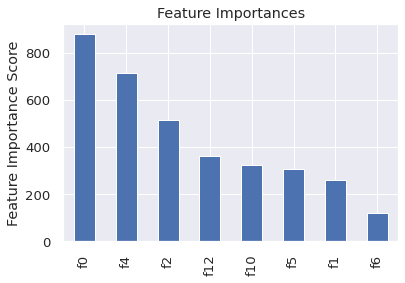

In [56]:
#https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/
params = {
 'learning_rate':[0.3],  #ideal: 0.01-0.2  
 'max_depth':[20],
 'min_child_weight':[2], # got 5 from GridSearch
 #'subsample':[i/10.0 for i in range(4,10,2)],
 'n_estimators':[1000],
 'colsample_bytree':[1],
 'scale_pos_weight':[0.5, 1, 1.5, 2, 3]
}

cluster = LocalCUDACluster()
client = Client(cluster)
from joblib import parallel_backend

with LocalCUDACluster() as cluster:
    with Client(cluster) as client:
        #grid_xgb, y_pred_train_xgb, y_predprob_train_xgb, y_pred_test_xgb, y_predprob_test_xgb, xgb_hist = modelfit(x_train_res, y_train_res, x_test, y_test, params, client)
        grid_xgb, grid_result_xgb, y_pred_test_xgb, y_predprob_test_xgb = modelfit(x_train_res, y_train_res, x_test, y_test, params, client)
        

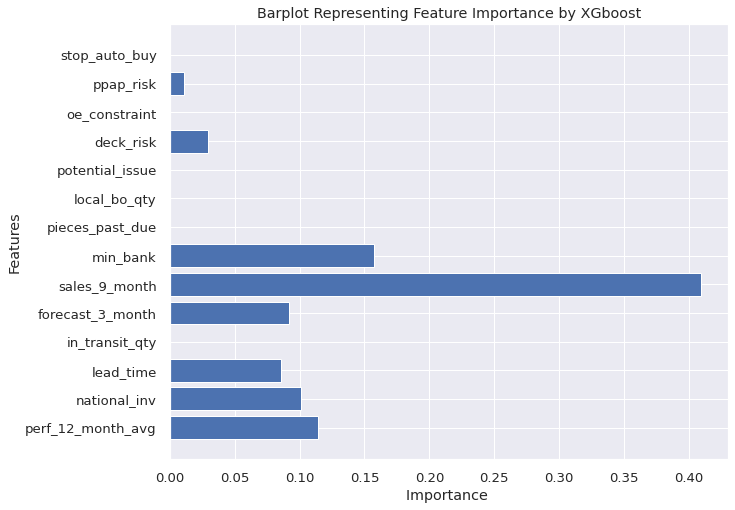

In [57]:
imp_feature = pd.DataFrame({'Feature': df.columns[:-1], 'Importance': grid_result_xgb.feature_importances_})
plt.figure(figsize=(10,8))
plt.title("Barplot Representing Feature Importance by XGboost")
plt.xlabel("Importance ")
plt.ylabel("Features")
plt.barh(imp_feature['Feature'],imp_feature['Importance'])
plt.savefig("xgboost_feature_imp.png", bbox_inches='tight')
plt.show()

In [58]:
pd.DataFrame(grid_xgb.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_min_child_weight,param_n_estimators,param_scale_pos_weight,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,9.401095,1.758440,0.017140,0.004807,1,0.3,20,2,1000,0.5,"{'colsample_bytree': 1, 'learning_rate': 0.3, ...",0.912457,0.901180,0.914418,0.909351,0.005834,1
1,9.191784,1.266366,0.023293,0.007781,1,0.3,20,2,1000,1,"{'colsample_bytree': 1, 'learning_rate': 0.3, ...",0.901807,0.892919,0.896021,0.896916,0.003683,2
2,9.350663,1.382205,0.018003,0.005701,1,0.3,20,2,1000,1.5,"{'colsample_bytree': 1, 'learning_rate': 0.3, ...",0.896285,0.881051,0.890069,0.889135,0.006254,3
3,9.431308,1.331606,0.017256,0.006259,1,0.3,20,2,1000,2,"{'colsample_bytree': 1, 'learning_rate': 0.3, ...",0.896285,0.874883,0.888193,0.886454,0.008824,4
4,9.626492,1.535235,0.016883,0.003266,1,0.3,20,2,1000,3,"{'colsample_bytree': 1, 'learning_rate': 0.3, ...",0.887429,0.868895,0.884009,0.880111,0.008053,5


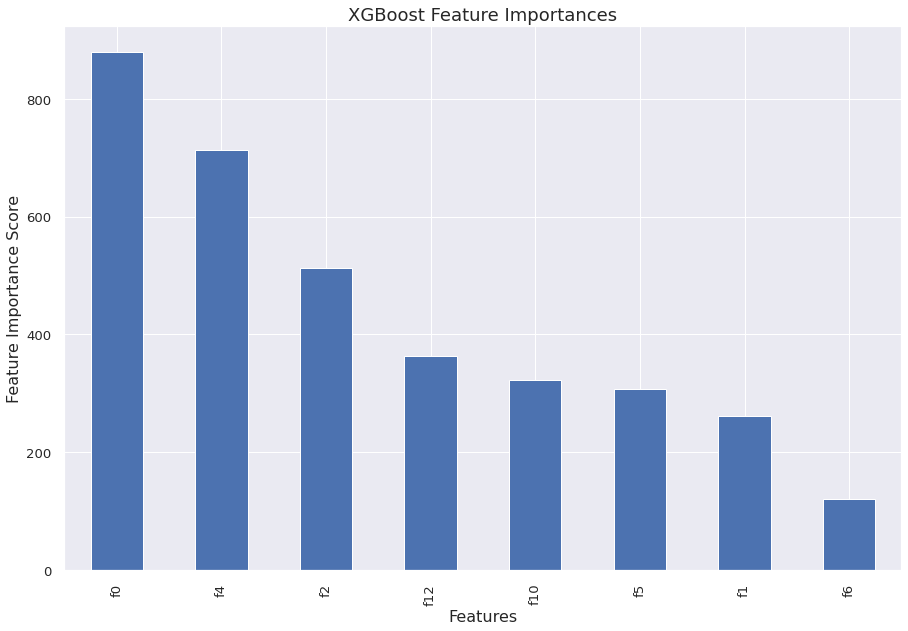

In [59]:
feat_imp = pd.Series(grid_result_xgb.get_booster().get_score()).sort_values(ascending=False)
plt.figure(figsize=(15,10))
feat_imp.plot(kind='bar')
plt.title('XGBoost Feature Importances', fontsize=18)
plt.ylabel('Feature Importance Score', fontsize=16)   
plt.xlabel('Features', fontsize=16)
plt.savefig("xgb_imp_features.png")

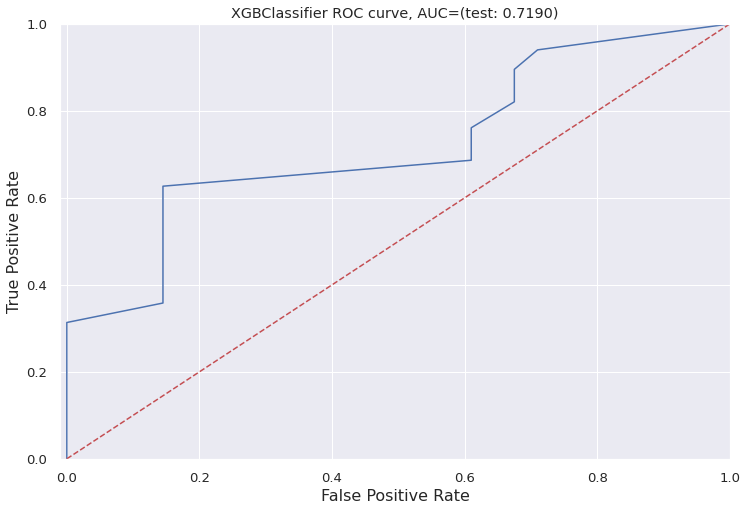

In [60]:
#plt.plot(iterations, train_history["validation_0"]["aucpr"], label="training data")
#plt.plot(iterations, train_history["validation_1"]["aucpr"], label="test data")
fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(y_test, y_predprob_test_xgb)
auc_test = sklearn.metrics.auc(fpr_test, tpr_test)
plt.figure(figsize=(12,8))
plt.title(f"XGBClassifier ROC curve, AUC=(test: {auc_test:.4f})")
plt.plot(fpr_test, tpr_test, label="test data")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.axis([-0.01,1,0,1])
plt.savefig("xgb_roc_auc.png")

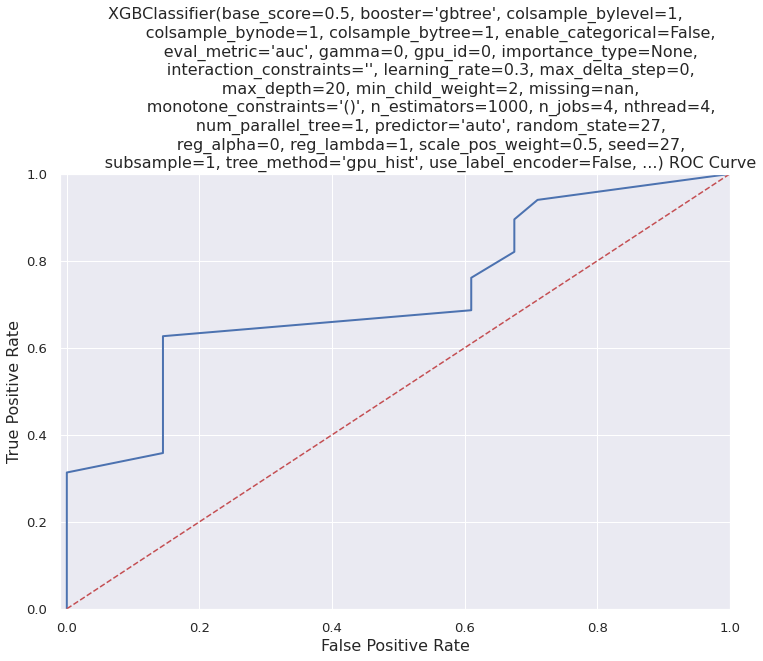

In [61]:
def roc_curve(model, fpr, tpr):
    plt.figure(figsize=(12,8))
    plt.title('{} ROC Curve'.format(model), fontsize=16)
    plt.plot(fpr, tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
roc_curve(grid_result_xgb, fpr_test, tpr_test)
plt.show()

Text(0.5, 1.0, 'Precision-Recall curve:\nAverage Precision-Recall Score =0.58')

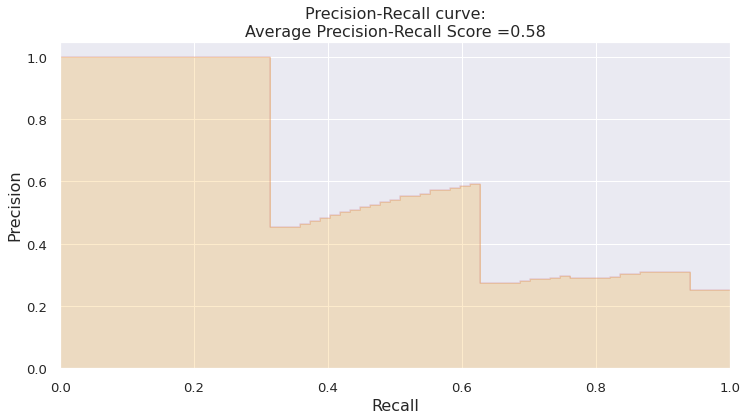

In [62]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_predprob_test_xgb)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve:\nAverage Precision-Recall Score ={0:0.2f}'.format(
          sklearn.metrics.average_precision_score(y_test, y_predprob_test_xgb)), fontsize=16)

In [63]:
print(sklearn.metrics.classification_report(y_test, y_pred_test_xgb))

              precision    recall  f1-score   support

           0       0.88      0.33      0.47       200
           1       0.30      0.87      0.45        67

    accuracy                           0.46       267
   macro avg       0.59      0.60      0.46       267
weighted avg       0.73      0.46      0.47       267



In [67]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred_test_xgb))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.33      0.87      0.47      0.53      0.27       200
          1       0.30      0.87      0.33      0.45      0.53      0.30        67

avg / total       0.73      0.46      0.73      0.47      0.53      0.27       267



In [65]:
grid_xgb.best_params_, grid_xgb.best_score_

({'colsample_bytree': 1,
  'learning_rate': 0.3,
  'max_depth': 20,
  'min_child_weight': 2,
  'n_estimators': 1000,
  'scale_pos_weight': 0.5},
 0.9093514147665998)

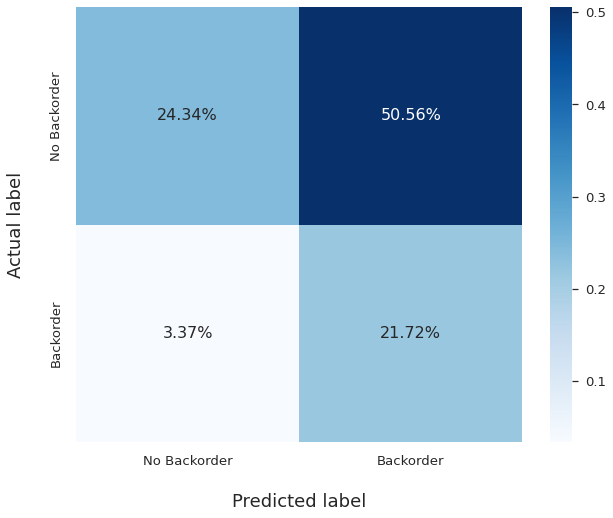

In [64]:
confusionMatrix = confusion_matrix(y_test,y_pred_test_xgb,labels=[0,1])
cm_xgb = confusion_matrix(y_test,y_pred_test_xgb)

fig, ax = plt.subplots(figsize=(10,8))
sns.set(font_scale=1.2)
sns.heatmap(cm_xgb/np.sum(cm_xgb), fmt='.2%', annot=True, annot_kws={"size": 16}, cmap='Blues', cbar=True, xticklabels=['No Backorder','Backorder'], yticklabels=['No Backorder','Backorder'], ax=ax)
plt.grid(False)
plt.xlabel('\nPredicted label', fontsize=18)
plt.ylabel('Actual label\n', fontsize=18)
plt.savefig('xgb_confusion_matrix.png')
plt.show()

In [66]:
grid_result = grid_xgb
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

0.909351 (0.005834) with: {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 20, 'min_child_weight': 2, 'n_estimators': 1000, 'scale_pos_weight': 0.5}
0.896916 (0.003683) with: {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 20, 'min_child_weight': 2, 'n_estimators': 1000, 'scale_pos_weight': 1}
0.889135 (0.006254) with: {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 20, 'min_child_weight': 2, 'n_estimators': 1000, 'scale_pos_weight': 1.5}
0.886454 (0.008824) with: {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 20, 'min_child_weight': 2, 'n_estimators': 1000, 'scale_pos_weight': 2}
0.880111 (0.008053) with: {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 20, 'min_child_weight': 2, 'n_estimators': 1000, 'scale_pos_weight': 3}
Best: 0.909351 using {'colsample_bytree': 1, 'learning_rate': 0.3, 'max_depth': 20, 'min_child_weight': 2, 'n_estimators': 1000, 'scale_pos_weight': 0.5}


max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.\
min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.\
gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.\
subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.\
scale_pos_weight = 1: Because of high class imbalance.

## Neural Network

In [68]:
# Model and performance
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from keras.layers import Dense
from keras.models import Sequential
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.utils import class_weight

In [69]:
# Calculate weights using sklearn
sklearn_weights = class_weight.compute_class_weight('balanced', classes= np.unique(y_train_res), y=y_train_res)
sklearn_weights

array([1., 1.])

In [70]:
# Transform array to dictionary
sklearn_weights = dict(enumerate(sklearn_weights))
sklearn_weights

{0: 1.0, 1: 1.0}

In [71]:
# instantiating the model in the strategy scope creates the model on the TPU
#with tpu_strategy.scope():
with LocalCUDACluster() as cluster:
    with Client(cluster) as client:
        # Train the neural network model using the imbalanced dataset
        # Create model
        nn_model_balanced = Sequential()
        nn_model_balanced.add(Dense(10,input_dim=x_train_res.shape[1],activation='relu'))
        nn_model_balanced.add(Dense(1,activation='sigmoid'))
        #Compile model
        nn_model_balanced.compile(loss='binary_crossentropy',optimizer='adam')
        #Fit the model
        #using 2 class weights [{0: 0.6666666666666666, 1: 2.0}, {0: 1, 1: 1.5}]
        nn_model_balanced.fit(x_train_res,y_train_res, epochs=50, batch_size=100, class_weight={0: 1, 1: 1.5})
        # Prediction
        nn_model_balanced_prediction = nn_model_balanced.predict(x_test)
        nn_model_balanced_classes = [1 if i>0.5 else 0 for i in nn_model_balanced_prediction]
        # Check the model performance
        print(classification_report(y_test, nn_model_balanced_classes))

distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.worker - WARNING - Mismatched versions found

+-------------+-------------+-----------+-----------+
| Package     | This Worker | scheduler | workers   |
+-------------+-------------+-----------+-----------+
| dask        | 2022.01.0   | 2022.02.0 | 2022.01.0 |
| distributed | 2022.01.0   | 2022.02.0 | 2022.01.0 |
+-------------+-------------+-----------+-----------+
distributed.worker - WARNING - Mismatched versions found

+-------------+-------------+-----------+-----------+
| Package     | This Worker | scheduler | workers   |
+-------------+-------------+-----------+-----------+
| dask        | 2022.01.0   | 2022.02.0 | 2022.01.0 |
| distributed | 2022.01.0   | 2022.02.0 | 2022.01.0 |
+-------------+-------------+-----------+-----------+


Epoch 1/50
10/10 [==============================] - 3s 3ms/step - loss: 0.9232
Epoch 2/50
10/10 [==============================] - 0s 5ms/step - loss: 0.8809
Epoch 3/50
10/10 [==============================] - 0s 6ms/step - loss: 0.8524
Epoch 4/50
10/10 [==============================] - 0s 4ms/step - loss: 0.8309
Epoch 5/50
10/10 [==============================] - 0s 5ms/step - loss: 0.8171
Epoch 6/50
10/10 [==============================] - 0s 4ms/step - loss: 0.8038
Epoch 7/50
10/10 [==============================] - 0s 5ms/step - loss: 0.7941
Epoch 8/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7850
Epoch 9/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7763
Epoch 10/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7680
Epoch 11/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7607
Epoch 12/50
10/10 [==============================] - 0s 4ms/step - loss: 0.7534
Epoch 13/50
10/10 [==============================

In [75]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, nn_model_balanced_classes))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.87      0.47      0.79      0.61      0.61      0.36       200
          1       0.33      0.79      0.47      0.47      0.61      0.38        67

avg / total       0.74      0.55      0.71      0.57      0.61      0.37       267



In [72]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, nn_model_balanced_classes)

array([[ 94, 106],
       [ 14,  53]])

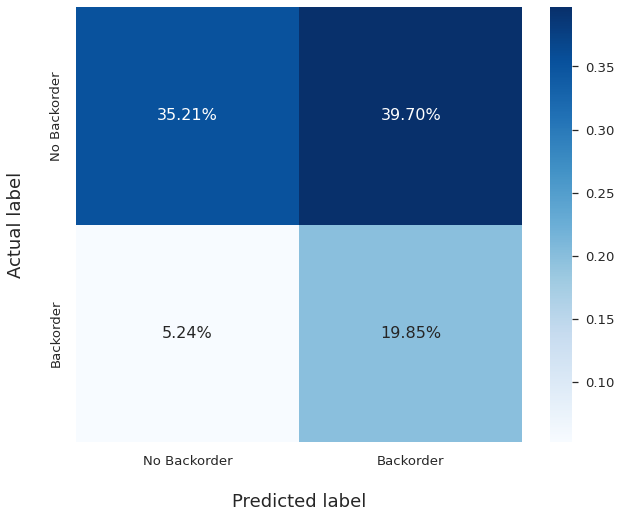

In [73]:
confusionMatrix = confusion_matrix(y_test,nn_model_balanced_classes,labels=[0,1])
cm_nn = confusion_matrix(y_test,nn_model_balanced_classes)
fig, ax = plt.subplots(figsize=(10,8))
sns.set(font_scale=1.2)
sns.heatmap(cm_nn/np.sum(cm_nn), fmt='.2%', annot=True, annot_kws={"size": 16}, cmap='Blues', cbar=True, xticklabels=['No Backorder','Backorder'], yticklabels=['No Backorder','Backorder'], ax=ax)
plt.grid(False)
plt.xlabel('\nPredicted label', fontsize=18)
plt.ylabel('Actual label\n', fontsize=18)
plt.savefig('nn2_confusion_matrix.png')
plt.show()

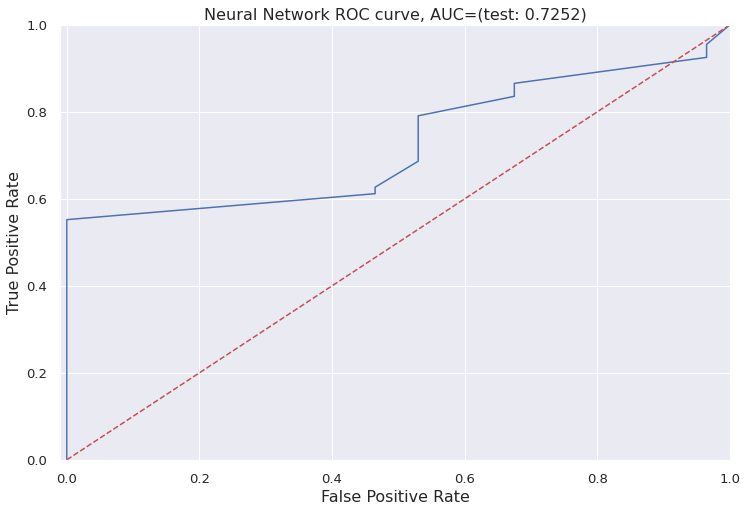

In [74]:
fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(y_test, nn_model_balanced_prediction)
auc_test = sklearn.metrics.auc(fpr_test, tpr_test)
plt.figure(figsize=(12,8))
plt.title(f"Neural Network ROC curve, AUC=(test: {auc_test:.4f})", fontsize=16)
plt.plot(fpr_test, tpr_test, label="test data")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.axis([-0.01,1,0,1])
plt.savefig("nn2_roc_auc.png")

Text(0.5, 1.0, 'Precision-Recall curve:\nAverage Precision-Recall Score =0.68')

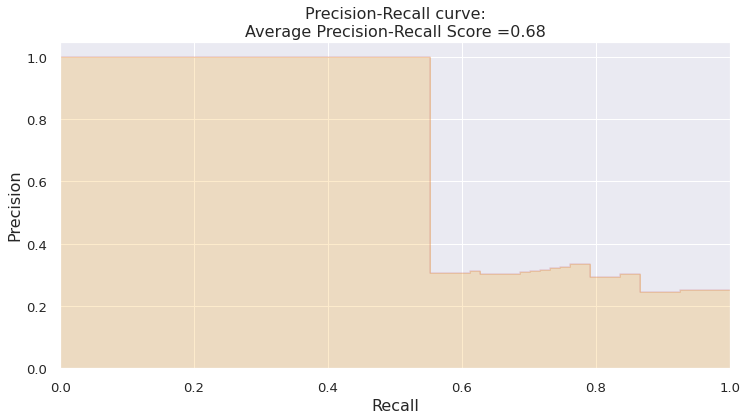

In [76]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, nn_model_balanced_prediction)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve:\nAverage Precision-Recall Score ={0:0.2f}'.format(
          sklearn.metrics.average_precision_score(y_test, nn_model_balanced_prediction)), fontsize=16)

# Logistic Regression

In [77]:
def modelfit(x_train, y_train, x_test, y_test, params, client, early_stopping_rounds=100):    
    alg = LogisticRegression(solver='liblinear',multi_class='auto')
    #cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True)
    grid_log = sklearn.model_selection.GridSearchCV(estimator = alg, param_grid = params, cv=3, verbose=2, scoring='roc_auc')
    
    #Fit the algorithm on the data
    #grid_xgb.fit(x_train, y_train, eval_set=eval_s, early_stopping_rounds=100)
    grid_log.fit(x_train, y_train)
    grid_log = grid_log
    grid_result_log = grid_log.best_estimator_
    
    #train_history = grid_result.evals_result()
    y_pred_test_log = grid_result_log.predict(x_test)
    y_predprob_test_log = grid_result_log.predict_proba(x_test)[:,1]
   
    #return grid_result, y_pred_train, y_predprob_train, y_pred_test, y_predprob_test, train_history
    return grid_log, grid_result_log, y_pred_test_log, y_predprob_test_log
    

In [78]:
#https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/
params = {
 'C': [0.001, 0.01, 0.1, 1, 5, 10, 100, 1000],  
 'penalty': ['l1', 'l2'],
 'class_weight':[{0:1.0, 1:3.0}, {0:1.0, 1:1.5},{0:1.0, 1:2.0},{0:1.0, 1:1.0}, 'balanced']
}

cluster = LocalCUDACluster()
client = Client(cluster)

with LocalCUDACluster() as cluster:
    with Client(cluster) as client:
        #grid_xgb, y_pred_train_xgb, y_predprob_train_xgb, y_pred_test_xgb, y_predprob_test_xgb, xgb_hist = modelfit(x_train_res, y_train_res, x_test, y_test, params, client)
        grid_log, grid_result_log, y_pred_test_log, y_predprob_test_log = modelfit(x_train_res, y_train_res, x_test, y_test, params, client)       

distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.worker - WARNING - Mismatched versions found

+-------------+-------------+-----------+-----------+
| Package     | This Worker | scheduler | workers   |
+-------------+-------------+-----------+-----------+
| dask        | 2022.01.0   | 2022.02.0 | 2022.01.0 |
| distributed | 2022.01.0   | 2022.02.0 | 2022.01.0 |
+-------------+-------------+-----------+-----------+
distributed.worker - WARNING - Mismatched versions found

+-------------+-------------+-----------+-----------+
| Package     | This Worker | scheduler | workers   |
+-------------+-------------+-----------+-----------+
| dask        | 2022.01.0   | 2022.02.0 | 2022.01.0 |
| distributed | 2022.01.0   | 2022.02.0 | 2022.01.0 |
+-------------+-------------+-----------+-----------+
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distribu

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV] END .C=0.001, class_weight={0: 1.0, 1: 3.0}, penalty=l1; total time=   0.0s
[CV] END .C=0.001, class_weight={0: 1.0, 1: 3.0}, penalty=l1; total time=   0.0s
[CV] END .C=0.001, class_weight={0: 1.0, 1: 3.0}, penalty=l1; total time=   0.0s
[CV] END .C=0.001, class_weight={0: 1.0, 1: 3.0}, penalty=l2; total time=   0.0s
[CV] END .C=0.001, class_weight={0: 1.0, 1: 3.0}, penalty=l2; total time=   0.0s
[CV] END .C=0.001, class_weight={0: 1.0, 1: 3.0}, penalty=l2; total time=   0.0s
[CV] END .C=0.001, class_weight={0: 1.0, 1: 1.5}, penalty=l1; total time=   0.0s
[CV] END .C=0.001, class_weight={0: 1.0, 1: 1.5}, penalty=l1; total time=   0.0s
[CV] END .C=0.001, class_weight={0: 1.0, 1: 1.5}, penalty=l1; total time=   0.0s
[CV] END .C=0.001, class_weight={0: 1.0, 1: 1.5}, penalty=l2; total time=   0.0s
[CV] END .C=0.001, class_weight={0: 1.0, 1: 1.5}, penalty=l2; total time=   0.0s
[CV] END .C=0.001, class_weight={0: 1.0, 1: 1.5

In [79]:
print(sklearn.metrics.classification_report(y_test, y_pred_test_log))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92       200
           1       0.78      0.70      0.74        67

    accuracy                           0.88       267
   macro avg       0.84      0.82      0.83       267
weighted avg       0.87      0.88      0.87       267



In [84]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred_test_log))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.90      0.94      0.70      0.92      0.81      0.67       200
          1       0.78      0.70      0.94      0.74      0.81      0.64        67

avg / total       0.87      0.88      0.76      0.87      0.81      0.66       267



In [80]:
pd.DataFrame(grid_log.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_class_weight,param_penalty,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.009710,0.009322,0.006771,0.002693,0.001,"{0: 1.0, 1: 3.0}",l1,"{'C': 0.001, 'class_weight': {0: 1.0, 1: 3.0},...",0.500000,0.500000,0.500000,0.500000,0.000000,76
1,0.002849,0.000660,0.003853,0.001285,0.001,"{0: 1.0, 1: 3.0}",l2,"{'C': 0.001, 'class_weight': {0: 1.0, 1: 3.0},...",0.695830,0.694665,0.727238,0.705911,0.015088,70
2,0.002282,0.000607,0.004415,0.002531,0.001,"{0: 1.0, 1: 1.5}",l1,"{'C': 0.001, 'class_weight': {0: 1.0, 1: 1.5},...",0.500000,0.500000,0.500000,0.500000,0.000000,76
3,0.005839,0.001344,0.003164,0.000240,0.001,"{0: 1.0, 1: 1.5}",l2,"{'C': 0.001, 'class_weight': {0: 1.0, 1: 1.5},...",0.755029,0.751731,0.769948,0.758903,0.007925,68
4,0.002841,0.000905,0.003268,0.001281,0.001,"{0: 1.0, 1: 2.0}",l1,"{'C': 0.001, 'class_weight': {0: 1.0, 1: 2.0},...",0.500000,0.500000,0.500000,0.500000,0.000000,76
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.010538,0.000873,0.004377,0.001267,1000,"{0: 1.0, 1: 2.0}",l2,"{'C': 1000, 'class_weight': {0: 1.0, 1: 2.0}, ...",0.867833,0.862005,0.891729,0.873856,0.012860,14
76,0.351516,0.258681,0.003277,0.001061,1000,"{0: 1.0, 1: 1.0}",l1,"{'C': 1000, 'class_weight': {0: 1.0, 1: 1.0}, ...",0.867761,0.861067,0.890250,0.873026,0.012482,27
77,0.017046,0.009546,0.005709,0.002529,1000,"{0: 1.0, 1: 1.0}",l2,"{'C': 1000, 'class_weight': {0: 1.0, 1: 1.0}, ...",0.867690,0.865324,0.890177,0.874397,0.011200,4
78,0.285695,0.224622,0.006644,0.005220,1000,balanced,l1,"{'C': 1000, 'class_weight': 'balanced', 'penal...",0.867761,0.861139,0.890250,0.873050,0.012459,25


In [81]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_test_log)

array([[187,  13],
       [ 20,  47]])

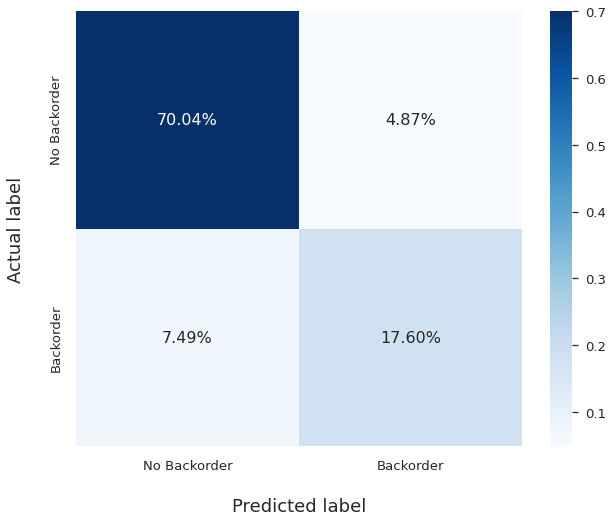

In [82]:
confusionMatrix = confusion_matrix(y_test,y_pred_test_log,labels=[0,1])
cm_lr = confusion_matrix(y_test,y_pred_test_log)
fig, ax = plt.subplots(figsize=(10,8))
sns.set(font_scale=1.2)
sns.heatmap(cm_lr/np.sum(cm_lr), fmt='.2%', annot=True, annot_kws={"size": 16}, cmap='Blues', cbar=True, xticklabels=['No Backorder','Backorder'], yticklabels=['No Backorder','Backorder'], ax=ax)
plt.grid(False)
plt.xlabel('\nPredicted label', fontsize=18)
plt.ylabel('Actual label\n', fontsize=18)
plt.savefig('log_confusion_matrix.png')

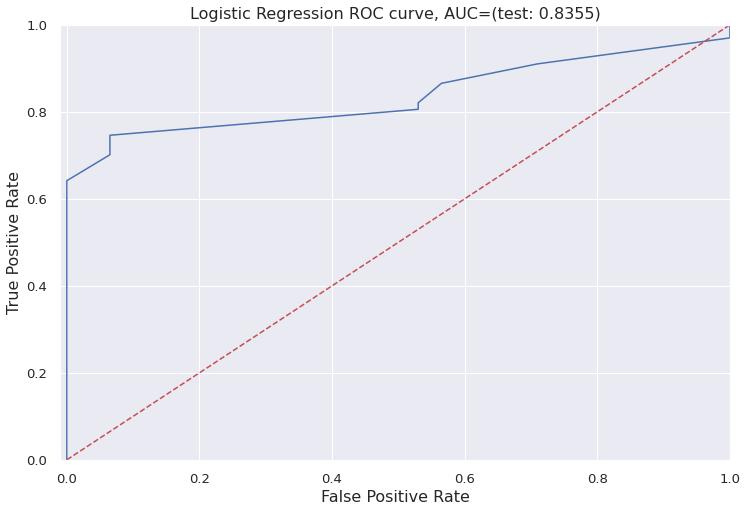

In [83]:
fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(y_test, y_predprob_test_log)
auc_test = sklearn.metrics.auc(fpr_test, tpr_test)
plt.figure(figsize=(12,8))
plt.title(f"Logistic Regression ROC curve, AUC=(test: {auc_test:.4f})", fontsize=16)
plt.plot(fpr_test, tpr_test, label="test data")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.axis([-0.01,1,0,1])
plt.savefig("log_roc_auc.png")

Text(0.5, 1.0, 'Precision-Recall curve:\nAverage Precision-Recall Score =0.80')

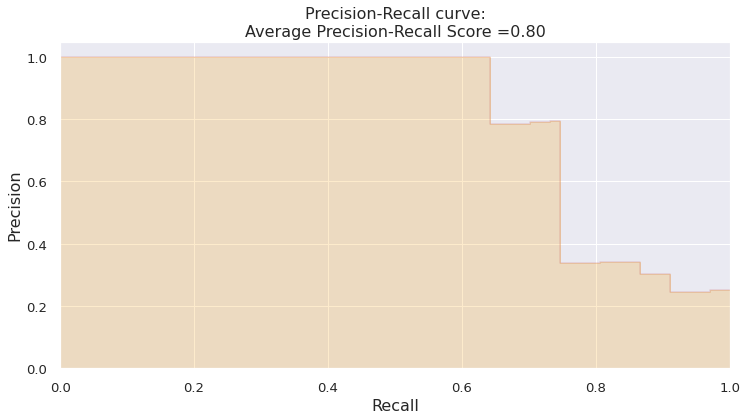

In [85]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_predprob_test_log)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve:\nAverage Precision-Recall Score ={0:0.2f}'.format(
          sklearn.metrics.average_precision_score(y_test, y_predprob_test_log)), fontsize=16)

# KNN

In [86]:
def modelfit(x_train, y_train, x_test, y_test, params, client, early_stopping_rounds=100):    
    alg = KNeighborsClassifier()
    #cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True)
    grid_log = sklearn.model_selection.GridSearchCV(estimator = alg, param_grid = params, cv=3, verbose=2, scoring='roc_auc')
    
    #Fit the algorithm on the data
    #grid_xgb.fit(x_train, y_train, eval_set=eval_s, early_stopping_rounds=100)
    grid_log.fit(x_train, y_train)
    grid_log = grid_log
    grid_result_log = grid_log.best_estimator_
    
    #train_history = grid_result.evals_result()
    y_pred_test_log = grid_result_log.predict(x_test)
    y_predprob_test_log = grid_result_log.predict_proba(x_test)[:,1]
   
    #return grid_result, y_pred_train, y_predprob_train, y_pred_test, y_predprob_test, train_history
    return grid_log, grid_result_log, y_pred_test_log, y_predprob_test_log

#https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/
params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

cluster = LocalCUDACluster()
client = Client(cluster)

with LocalCUDACluster() as cluster:
    with Client(cluster) as client:
        #grid_xgb, y_pred_train_xgb, y_predprob_train_xgb, y_pred_test_xgb, y_predprob_test_xgb, xgb_hist = modelfit(x_train_res, y_train_res, x_test, y_test, params, client)
        grid_knn, grid_result_knn, y_pred_test_knn, y_predprob_test_knn = modelfit(x_train_res, y_train_res, x_test, y_test, params, client)       

distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.worker - WARNING - Mismatched versions found

+-------------+-------------+-----------+-----------+
| Package     | This Worker | scheduler | workers   |
+-------------+-------------+-----------+-----------+
| dask        | 2022.01.0   | 2022.02.0 | 2022.01.0 |
| distributed | 2022.01.0   | 2022.02.0 | 2022.01.0 |
+-------------+-------------+-----------+-----------+
distributed.worker - WARNING - Mismatched versions found

+-------------+-------------+-----------+-----------+
| Package     | This Worker | scheduler | workers   |
+-------------+-------------+-----------+-----------+
| dask        | 2022.01.0   | 2022.02.0 | 2022.01.0 |
| distributed | 2022.01.0   | 2022.02.0 | 2022.01.0 |
+-------------+-------------+-----------+-----------+
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distribu

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] END ......................algorithm=auto, n_neighbors=2; total time=   0.0s
[CV] END ......................algorithm=auto, n_neighbors=2; total time=   0.0s
[CV] END ......................algorithm=auto, n_neighbors=2; total time=   0.0s
[CV] END ......................algorithm=auto, n_neighbors=3; total time=   0.0s
[CV] END ......................algorithm=auto, n_neighbors=3; total time=   0.0s
[CV] END ......................algorithm=auto, n_neighbors=3; total time=   0.0s
[CV] END ......................algorithm=auto, n_neighbors=4; total time=   0.0s
[CV] END ......................algorithm=auto, n_neighbors=4; total time=   0.0s
[CV] END ......................algorithm=auto, n_neighbors=4; total time=   0.0s
[CV] END .................algorithm=ball_tree, n_neighbors=2; total time=   0.0s
[CV] END .................algorithm=ball_tree, n_neighbors=2; total time=   0.0s
[CV] END .................algorithm=ball_tree, n

In [87]:
print(sklearn.metrics.classification_report(y_test, y_pred_test_knn))

              precision    recall  f1-score   support

           0       0.81      0.39      0.53       200
           1       0.29      0.73      0.41        67

    accuracy                           0.48       267
   macro avg       0.55      0.56      0.47       267
weighted avg       0.68      0.48      0.50       267



In [92]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred_test_knn))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.81      0.39      0.73      0.53      0.53      0.28       200
          1       0.29      0.73      0.39      0.41      0.53      0.29        67

avg / total       0.68      0.48      0.65      0.50      0.53      0.28       267



In [88]:
pd.DataFrame(grid_knn.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002598,0.000452,0.010748,0.004469,auto,2,"{'algorithm': 'auto', 'n_neighbors': 2}",0.828445,0.884388,0.849939,0.854257,0.023042,9
1,0.002220,0.000221,0.009752,0.003235,auto,3,"{'algorithm': 'auto', 'n_neighbors': 3}",0.852236,0.891855,0.882584,0.875558,0.016920,5
2,0.004349,0.001886,0.014479,0.003188,auto,4,"{'algorithm': 'auto', 'n_neighbors': 4}",0.857399,0.894957,0.884983,0.879113,0.015885,2
3,0.005951,0.002518,0.015551,0.002506,ball_tree,2,"{'algorithm': 'ball_tree', 'n_neighbors': 2}",0.822708,0.880492,0.849542,0.850914,0.023610,12
4,0.006451,0.001198,0.013264,0.001936,ball_tree,3,"{'algorithm': 'ball_tree', 'n_neighbors': 3}",0.851483,0.888157,0.884244,0.874628,0.016444,7
5,0.002392,0.000389,0.010704,0.003797,ball_tree,4,"{'algorithm': 'ball_tree', 'n_neighbors': 4}",0.858977,0.892955,0.887003,0.879645,0.014815,1
6,0.004588,0.001330,0.019271,0.012686,kd_tree,2,"{'algorithm': 'kd_tree', 'n_neighbors': 2}",0.828445,0.884388,0.849939,0.854257,0.023042,9
7,0.002746,0.000634,0.011218,0.001139,kd_tree,3,"{'algorithm': 'kd_tree', 'n_neighbors': 3}",0.852236,0.891855,0.882584,0.875558,0.016920,5
8,0.005549,0.003916,0.011582,0.004042,kd_tree,4,"{'algorithm': 'kd_tree', 'n_neighbors': 4}",0.857399,0.894957,0.884983,0.879113,0.015885,2
9,0.001685,0.000325,0.017590,0.007109,brute,2,"{'algorithm': 'brute', 'n_neighbors': 2}",0.823676,0.878977,0.855818,0.852824,0.022676,11


In [89]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_test_knn)

array([[ 78, 122],
       [ 18,  49]])

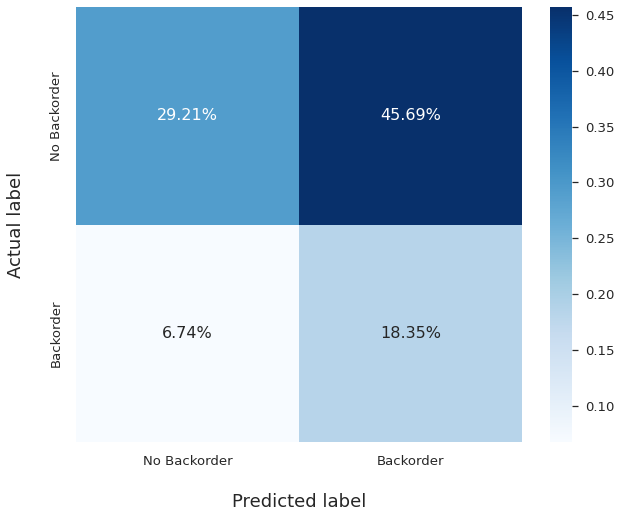

In [90]:
confusionMatrix = confusion_matrix(y_test,y_pred_test_knn,labels=[0,1])
cm_knn = confusion_matrix(y_test,y_pred_test_knn)
fig, ax = plt.subplots(figsize=(10,8))
sns.set(font_scale=1.2)
sns.heatmap(cm_knn/np.sum(cm_knn), fmt='.2%', annot=True, annot_kws={"size": 16}, cmap='Blues', cbar=True, xticklabels=['No Backorder','Backorder'], yticklabels=['No Backorder','Backorder'], ax=ax)
plt.grid(False)
plt.xlabel('\nPredicted label', fontsize=18)
plt.ylabel('Actual label\n', fontsize=18)
plt.savefig('knn_confusion_matrix.png')

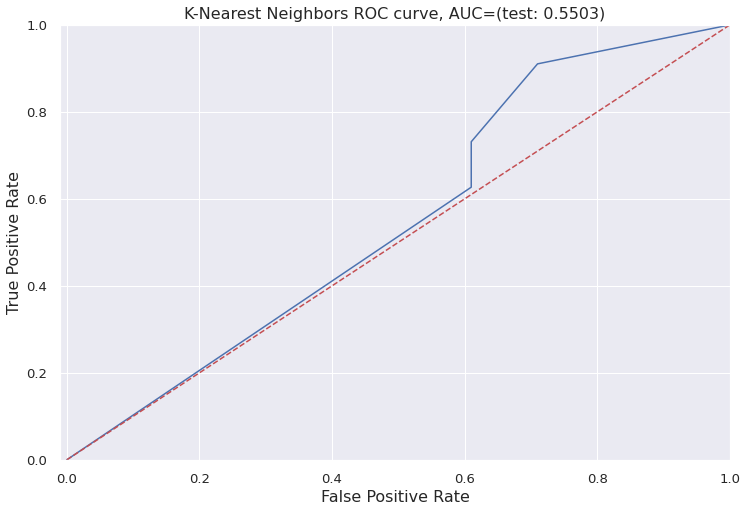

In [91]:
fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(y_test, y_predprob_test_knn)
auc_test = sklearn.metrics.auc(fpr_test, tpr_test)
plt.figure(figsize=(12,8))
plt.title(f"K-Nearest Neighbors ROC curve, AUC=(test: {auc_test:.4f})", fontsize=16)
plt.plot(fpr_test, tpr_test, label="test data")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.axis([-0.01,1,0,1])
plt.savefig("knn_roc_auc.png")

Text(0.5, 1.0, 'Precision-Recall curve:\nAverage Precision-Recall Score =0.27')

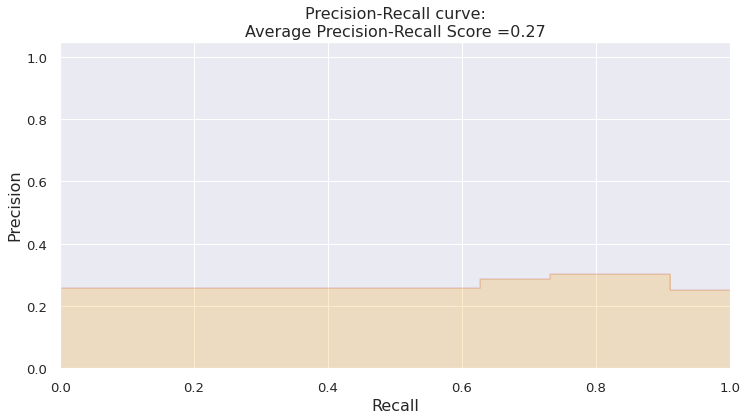

In [93]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_predprob_test_knn)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve:\nAverage Precision-Recall Score ={0:0.2f}'.format(
          sklearn.metrics.average_precision_score(y_test, y_predprob_test_knn)), fontsize=16)

# SVM

In [95]:
def modelfit(x_train, y_train, x_test, y_test, params, client, early_stopping_rounds=100):    
    alg = SVC(probability=True)
    #cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True)
    grid_log = sklearn.model_selection.GridSearchCV(estimator = alg, param_grid = params, cv=3, verbose=2, scoring='roc_auc')
    
    #Fit the algorithm on the data
    #grid_xgb.fit(x_train, y_train, eval_set=eval_s, early_stopping_rounds=100)
    grid_log.fit(x_train, y_train)
    grid_log = grid_log
    grid_result_log = grid_log.best_estimator_
    
    #train_history = grid_result.evals_result()
    y_pred_test_log = grid_result_log.predict(x_test)
    y_predprob_test_log = grid_result_log.predict_proba(x_test)[:,1]
   
    #return grid_result, y_pred_train, y_predprob_train, y_pred_test, y_predprob_test, train_history
    return grid_log, grid_result_log, y_pred_test_log, y_predprob_test_log

#https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/
params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}

cluster = LocalCUDACluster()
client = Client(cluster)

with LocalCUDACluster() as cluster:
    with Client(cluster) as client:
        #grid_xgb, y_pred_train_xgb, y_predprob_train_xgb, y_pred_test_xgb, y_predprob_test_xgb, xgb_hist = modelfit(x_train_res, y_train_res, x_test, y_test, params, client)
        grid_svm, grid_result_svm, y_pred_test_svm, y_predprob_test_svm = modelfit(x_train_res, y_train_res, x_test, y_test, params, client)       

distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.worker - WARNING - Mismatched versions found

+-------------+-------------+-----------+-----------+
| Package     | This Worker | scheduler | workers   |
+-------------+-------------+-----------+-----------+
| dask        | 2022.01.0   | 2022.02.0 | 2022.01.0 |
| distributed | 2022.01.0   | 2022.02.0 | 2022.01.0 |
+-------------+-------------+-----------+-----------+
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.worker - WARNING - Mismatched versions found

+-------------+-------------+-----------+-----------+
| Package     | This Worker | scheduler | workers   |
+-------------+-------------+-----------+-----------+
| dask        | 2022.01.0   | 2022.02.0 | 2022.01.0 |
| distributed | 2022.01.0   | 2022.02.0 | 2022.01.0 |
+-------------+-------------+-----------+-----------+
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distribu

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END ..................................C=0.5, kernel=rbf; total time=   0.6s
[CV] END ..................................C=0.5, kernel=rbf; total time=   0.6s
[CV] END ..................................C=0.5, kernel=rbf; total time=   0.5s
[CV] END .................................C=0.5, kernel=poly; total time=   0.5s
[CV] END .................................C=0.5, kernel=poly; total time=   0.4s
[CV] END .................................C=0.5, kernel=poly; total time=   0.3s
[CV] END ..............................C=0.5, kernel=sigmoid; total time=   0.6s
[CV] END ..............................C=0.5, kernel=sigmoid; total time=   0.5s
[CV] END ..............................C=0.5, kernel=sigmoid; total time=   0.5s
[CV] END ...............................C=0.5, kernel=linear; total time=   0.2s
[CV] END ...............................C=0.5, kernel=linear; total time=   0.2s
[CV] END ...............................C=0.5, k

In [96]:
print(sklearn.metrics.classification_report(y_test, y_pred_test_svm))

              precision    recall  f1-score   support

           0       0.84      0.39      0.53       200
           1       0.30      0.78      0.43        67

    accuracy                           0.49       267
   macro avg       0.57      0.58      0.48       267
weighted avg       0.70      0.49      0.51       267



In [101]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred_test_svm))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.84      0.39      0.78      0.53      0.55      0.29       200
          1       0.30      0.78      0.39      0.43      0.55      0.31        67

avg / total       0.70      0.49      0.68      0.51      0.55      0.30       267



In [97]:
pd.DataFrame(grid_svm.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.444293,0.021394,0.096307,0.041959,0.5,rbf,"{'C': 0.5, 'kernel': 'rbf'}",0.879845,0.875027,0.913120,0.889331,0.016936,6
1,0.352860,0.054924,0.033178,0.009492,0.5,poly,"{'C': 0.5, 'kernel': 'poly'}",0.872602,0.878238,0.896707,0.882515,0.010295,8
2,0.469035,0.044387,0.041098,0.013087,0.5,sigmoid,"{'C': 0.5, 'kernel': 'sigmoid'}",0.667216,0.607081,0.661659,0.645319,0.027133,13
3,0.203038,0.037620,0.030081,0.005239,0.5,linear,"{'C': 0.5, 'kernel': 'linear'}",0.837821,0.853816,0.884983,0.858874,0.019583,10
4,0.311832,0.078263,0.028525,0.005032,0.7,rbf,"{'C': 0.7, 'kernel': 'rbf'}",0.880813,0.882025,0.912939,0.891926,0.014867,5
5,0.228925,0.014815,0.028526,0.013741,0.7,poly,"{'C': 0.7, 'kernel': 'poly'}",0.881315,0.883468,0.898979,0.887921,0.007869,7
6,0.389739,0.046408,0.031071,0.005540,0.7,sigmoid,"{'C': 0.7, 'kernel': 'sigmoid'}",0.641723,0.576492,0.638536,0.618917,0.030027,14
7,0.760968,0.417846,0.074292,0.078068,0.7,linear,"{'C': 0.7, 'kernel': 'linear'}",0.837499,0.854430,0.886426,0.859451,0.020288,9
8,0.264759,0.031509,0.046433,0.019548,0.9,rbf,"{'C': 0.9, 'kernel': 'rbf'}",0.887949,0.891404,0.913011,0.897455,0.011090,1
9,0.268514,0.009465,0.026342,0.002202,0.9,poly,"{'C': 0.9, 'kernel': 'poly'}",0.884578,0.890538,0.903777,0.892964,0.008023,4


In [98]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_test_svm)

array([[ 78, 122],
       [ 15,  52]])

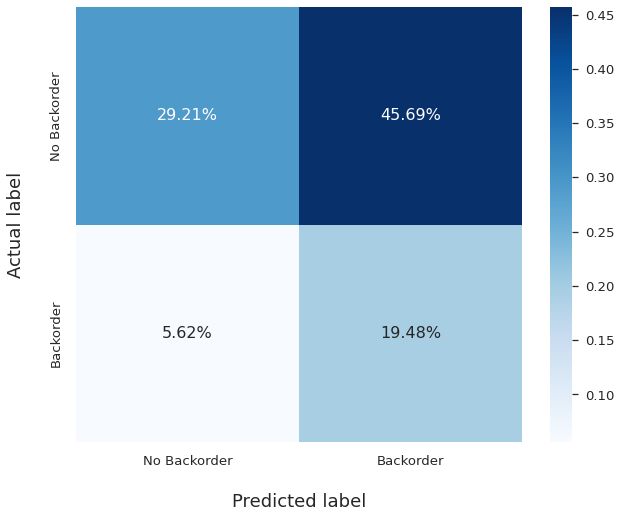

In [99]:
confusionMatrix = confusion_matrix(y_test,y_pred_test_svm,labels=[0,1])
cm_svm = confusion_matrix(y_test,y_pred_test_svm)
fig, ax = plt.subplots(figsize=(10,8))
sns.set(font_scale=1.2)
sns.heatmap(cm_svm/np.sum(cm_svm), fmt='.2%', annot=True, annot_kws={"size": 16}, cmap='Blues', cbar=True, xticklabels=['No Backorder','Backorder'], yticklabels=['No Backorder','Backorder'], ax=ax)
plt.grid(False)
plt.xlabel('\nPredicted label', fontsize=18)
plt.ylabel('Actual label\n', fontsize=18)
plt.savefig('svm_confusion_matrix.png')

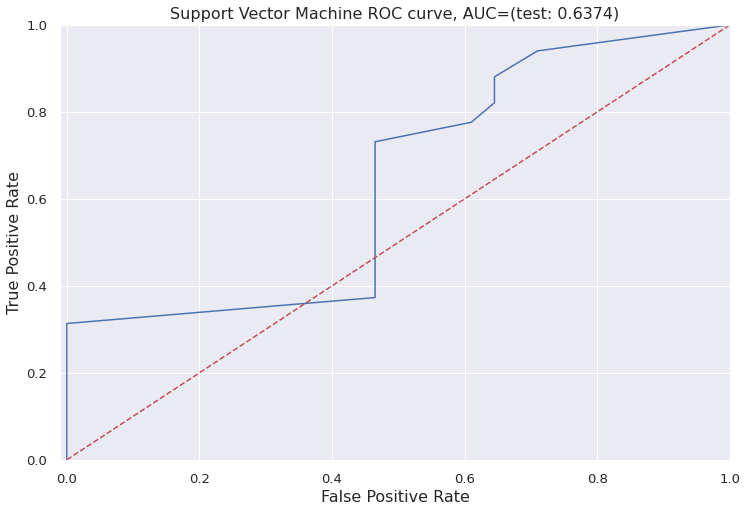

In [100]:
fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(y_test, y_predprob_test_svm)
auc_test = sklearn.metrics.auc(fpr_test, tpr_test)
plt.figure(figsize=(12,8))
plt.title(f"Support Vector Machine ROC curve, AUC=(test: {auc_test:.4f})", fontsize=16)
plt.plot(fpr_test, tpr_test, label="test data")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.axis([-0.01,1,0,1])
plt.savefig("svm_roc_auc.png")

Text(0.5, 1.0, 'Precision-Recall curve:\nAverage Precision-Recall Score =0.51')

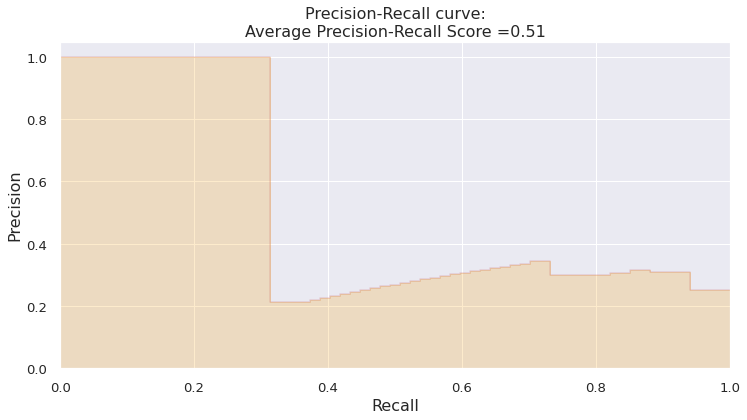

In [102]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_predprob_test_svm)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve:\nAverage Precision-Recall Score ={0:0.2f}'.format(
          sklearn.metrics.average_precision_score(y_test, y_predprob_test_svm)), fontsize=16)

# DT

In [103]:
def modelfit(x_train, y_train, x_test, y_test, params, client, early_stopping_rounds=100):    
    alg = DecisionTreeClassifier()
    #cv = sklearn.model_selection.StratifiedKFold(n_splits=5, shuffle=True)
    grid_log = sklearn.model_selection.GridSearchCV(estimator = alg, param_grid = params, cv=3, verbose=2, scoring='roc_auc')
    
    #Fit the algorithm on the data
    #grid_xgb.fit(x_train, y_train, eval_set=eval_s, early_stopping_rounds=100)
    grid_log.fit(x_train, y_train)
    grid_log = grid_log
    grid_result_log = grid_log.best_estimator_
    
    #train_history = grid_result.evals_result()
    y_pred_test_log = grid_result_log.predict(x_test)
    y_predprob_test_log = grid_result_log.predict_proba(x_test)[:,1]
   
    #return grid_result, y_pred_train, y_predprob_train, y_pred_test, y_predprob_test, train_history
    return grid_log, grid_result_log, y_pred_test_log, y_predprob_test_log
 
#https://machinelearningmastery.com/tune-number-size-decision-trees-xgboost-python/
params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}

cluster = LocalCUDACluster()
client = Client(cluster)

with LocalCUDACluster() as cluster:
    with Client(cluster) as client:
        #grid_xgb, y_pred_train_xgb, y_predprob_train_xgb, y_pred_test_xgb, y_predprob_test_xgb, xgb_hist = modelfit(x_train_res, y_train_res, x_test, y_test, params, client)
        grid_dt, grid_result_dt, y_pred_test_dt, y_predprob_test_dt = modelfit(x_train_res, y_train_res, x_test, y_test, params, client)       

distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distributed.worker - WARNING - Mismatched versions found

+-------------+-------------+-----------+-----------+
| Package     | This Worker | scheduler | workers   |
+-------------+-------------+-----------+-----------+
| dask        | 2022.01.0   | 2022.02.0 | 2022.01.0 |
| distributed | 2022.01.0   | 2022.02.0 | 2022.01.0 |
+-------------+-------------+-----------+-----------+
distributed.worker - WARNING - Mismatched versions found

+-------------+-------------+-----------+-----------+
| Package     | This Worker | scheduler | workers   |
+-------------+-------------+-----------+-----------+
| dask        | 2022.01.0   | 2022.02.0 | 2022.01.0 |
| distributed | 2022.01.0   | 2022.02.0 | 2022.01.0 |
+-------------+-------------+-----------+-----------+
distributed.preloading - INFO - Import preload module: dask_cuda.initialize
distribu

Fitting 3 folds for each of 8 candidates, totalling 24 fits
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=5; total time=   0.2s
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=5; total time=   0.1s
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=5; total time=   0.1s
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=6; total time=   0.1s
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=6; total time=   0.0s
[CV] END ....criterion=gini, max_depth=2, min_samples_leaf=6; total time=   0.1s
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=5; total time=   0.0s
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=5; total time=   0.0s
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=5; total time=   0.0s
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=6; total time=   0.0s
[CV] END ....criterion=gini, max_depth=3, min_samples_leaf=6; total time=   0.0s
[CV] END ....criterion=gini, max_depth=3, min_sam

In [104]:
print(sklearn.metrics.classification_report(y_test, y_pred_test_dt))

              precision    recall  f1-score   support

           0       0.88      0.33      0.47       200
           1       0.30      0.87      0.45        67

    accuracy                           0.46       267
   macro avg       0.59      0.60      0.46       267
weighted avg       0.73      0.46      0.47       267



In [109]:
from imblearn.metrics import classification_report_imbalanced
print(classification_report_imbalanced(y_test, y_pred_test_dt))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.88      0.33      0.87      0.47      0.53      0.27       200
          1       0.30      0.87      0.33      0.45      0.53      0.30        67

avg / total       0.73      0.46      0.73      0.47      0.53      0.27       267



In [105]:
pd.DataFrame(grid_dt.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.021013,0.000530,0.090913,0.069546,gini,2,5,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.796927,0.820846,0.833039,0.816937,0.014999,5
1,0.024366,0.006208,0.044270,0.018789,gini,2,6,"{'criterion': 'gini', 'max_depth': 2, 'min_sam...",0.796927,0.820846,0.833039,0.816937,0.014999,5
2,0.008200,0.004737,0.008902,0.003293,gini,3,5,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.855732,0.862131,0.879302,0.865721,0.009952,2
3,0.011400,0.005944,0.019517,0.015271,gini,3,6,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.855732,0.863989,0.879302,0.866341,0.009765,1
4,0.003740,0.000425,0.009229,0.004593,entropy,2,5,"{'criterion': 'entropy', 'max_depth': 2, 'min_...",0.739969,0.795451,0.829558,0.788326,0.036920,7
5,0.004966,0.001417,0.005754,0.003988,entropy,2,6,"{'criterion': 'entropy', 'max_depth': 2, 'min_...",0.739969,0.795451,0.829558,0.788326,0.036920,7
6,0.008216,0.007904,0.006069,0.002532,entropy,3,5,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.797339,0.820684,0.875767,0.831263,0.032880,3
7,0.041682,0.029178,0.029232,0.008986,entropy,3,6,"{'criterion': 'entropy', 'max_depth': 3, 'min_...",0.797339,0.820684,0.875767,0.831263,0.032880,3


In [106]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred_test_dt)

array([[ 65, 135],
       [  9,  58]])

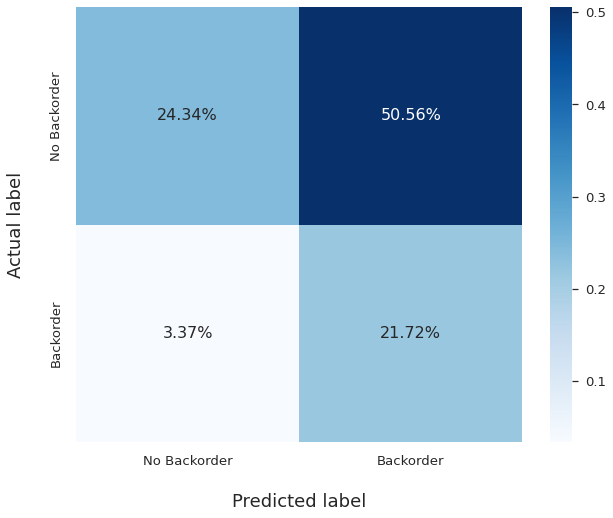

In [107]:
confusionMatrix = confusion_matrix(y_test,y_pred_test_dt,labels=[0,1])
cm_dt = confusion_matrix(y_test,y_pred_test_dt)
fig, ax = plt.subplots(figsize=(10,8))
sns.set(font_scale=1.2)
sns.heatmap(cm_dt/np.sum(cm_dt), fmt='.2%', annot=True, annot_kws={"size": 16}, cmap='Blues', cbar=True, xticklabels=['No Backorder','Backorder'], yticklabels=['No Backorder','Backorder'], ax=ax)
plt.grid(False)
plt.xlabel('\nPredicted label', fontsize=18)
plt.ylabel('Actual label\n', fontsize=18)
plt.savefig('dt_confusion_matrix.png')

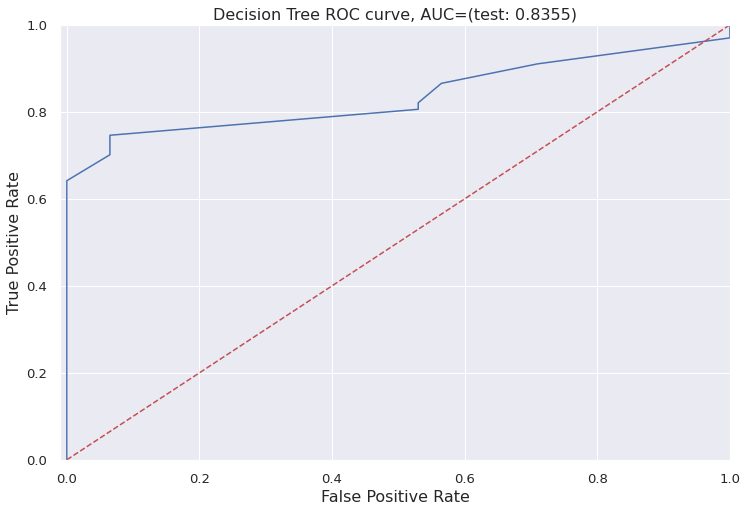

In [108]:
fpr_test, tpr_test, _ = sklearn.metrics.roc_curve(y_test, y_predprob_test_log)
auc_test = sklearn.metrics.auc(fpr_test, tpr_test)
plt.figure(figsize=(12,8))
plt.title(f"Decision Tree ROC curve, AUC=(test: {auc_test:.4f})", fontsize=16)
plt.plot(fpr_test, tpr_test, label="test data")
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.axis([-0.01,1,0,1])
plt.savefig("dt_roc_auc.png")

Text(0.5, 1.0, 'Precision-Recall curve:\nAverage Precision-Recall Score =0.60')

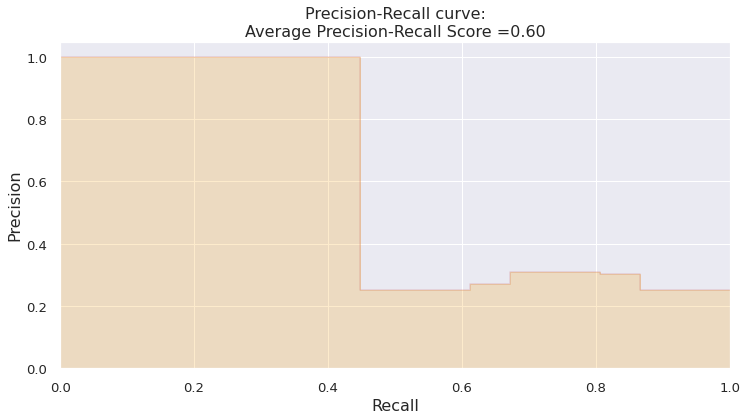

In [110]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = sklearn.metrics.precision_recall_curve(y_test, y_predprob_test_dt)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve:\nAverage Precision-Recall Score ={0:0.2f}'.format(
          sklearn.metrics.average_precision_score(y_test, y_predprob_test_dt)), fontsize=16)

# Plots

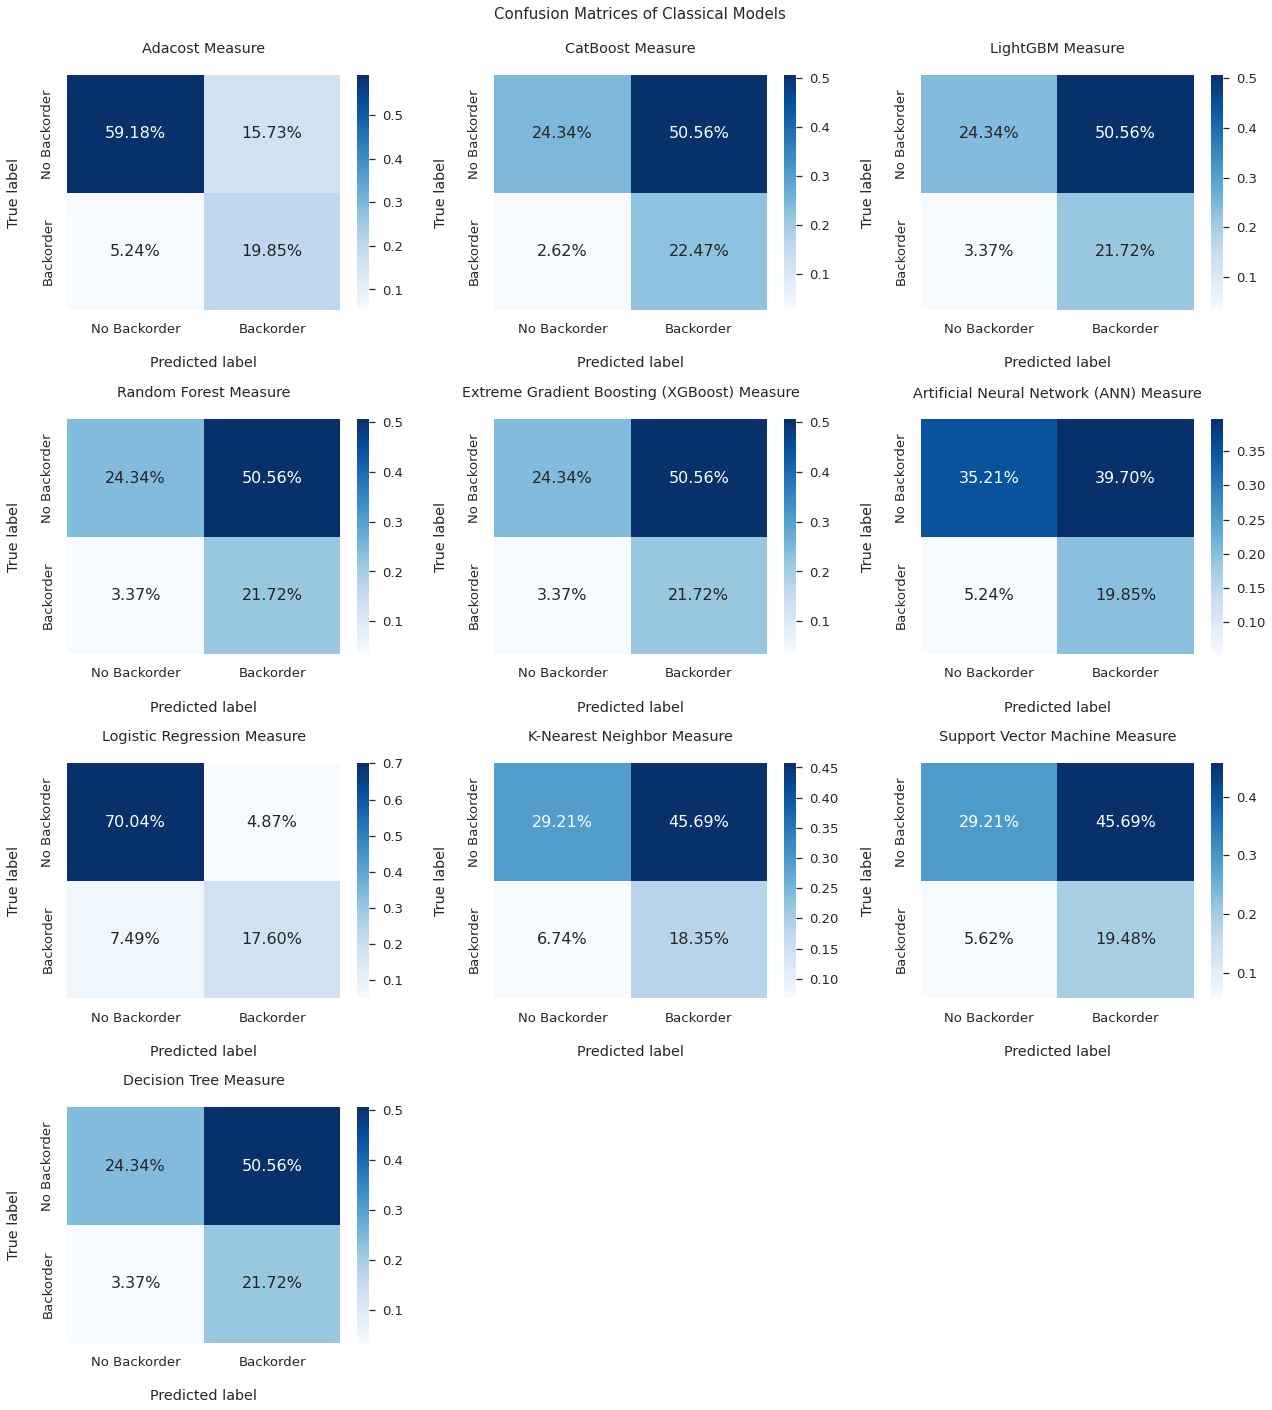

In [145]:
#@title
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt 
import seaborn as sns

l = [cm_ada,cm_cat,cm_lgb,cm_rf,cm_xgb,cm_nn,cm_lr,cm_knn,cm_svm,cm_dt]
l_names = ['Adacost','CatBoost','LightGBM','Random Forest','Extreme Gradient Boosting (XGBoost)',
          'Artificial Neural Network (ANN)','Logistic Regression','K-Nearest Neighbor','Support Vector Machine',
           'Decision Tree']
n_rows = 4
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 20))
axes = axes.ravel()
fig.suptitle('Confusion Matrices of Classical Models\n', fontsize=15) # Add title to main plot

for i, ax in enumerate(axes):
    if i >= len(l_names):
        fig.delaxes(ax)  # Delete the extra subplot
        continue
    cm = l[i]
    sns.set(font_scale=1.2)
    sns.heatmap(cm/np.sum(cm), fmt='.2%', annot=True, annot_kws={"size": 16}, cmap='Blues', cbar=True, xticklabels=['No Backorder','Backorder'], yticklabels=['No Backorder','Backorder'], ax=ax)
    ax.set_xlabel('\nPredicted label')
    ax.set_ylabel('True label\n')
    ax.set_title('{0} Measure\n'.format(l_names[i]))

plt.tight_layout()
# Save the figure to a file
plt.savefig('cm_6_classical.png')
plt.show()

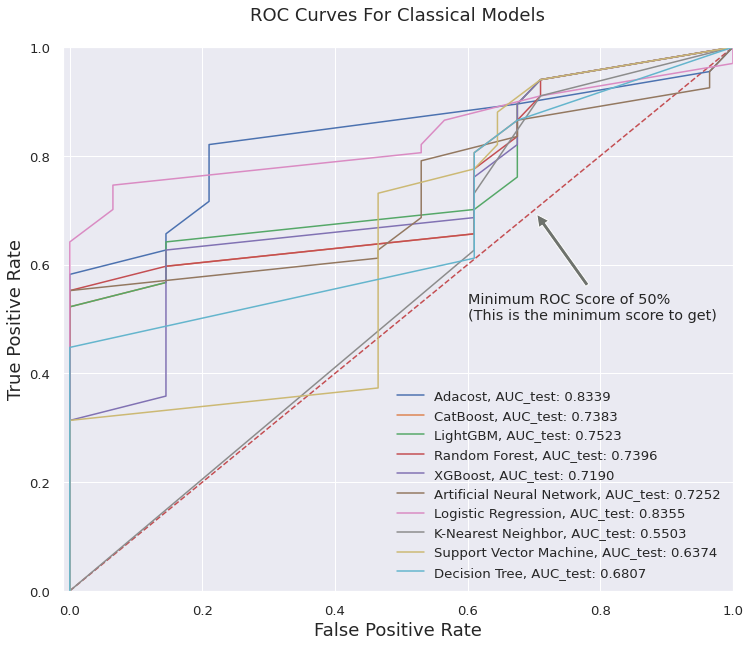

In [135]:
import matplotlib.pyplot as plt 
import seaborn as sns

l_names = ['Adacost','CatBoost','LightGBM','Random Forest','XGBoost',
          'Artificial Neural Network','Logistic Regression','K-Nearest Neighbor','Support Vector Machine',
           'Decision Tree']
y_predprob_test_names = [y_predprob_test_ada,y_predprob_test_cat,y_predprob_test_lgb,y_predprob_test_rf,y_predprob_test_xgb,nn_model_balanced_prediction,y_predprob_test_log,
                        y_predprob_test_knn,y_predprob_test_svm,y_predprob_test_dt]

plt.figure(figsize=(12,10))
plt.plot([0, 1], [0, 1], 'r--')
plt.annotate('Minimum ROC Score of 50%\n(This is the minimum score to get)', xy=(0.7, 0.7), xytext=(0.6, 0.5),
            arrowprops=dict(facecolor='#6E726D', shrink=0.05),
            )   

for i, names in enumerate(l_names):
    fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_predprob_test_names[i])
    auc = sklearn.metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label='{0}, AUC_test: {1:.4f}'.format(l_names[i],auc))
    plt.legend()
    
 
plt.title('ROC Curves For Classical Models\n', fontsize=18) # Add title to main plot
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.axis([-0.01,1,0,1])
# Save the figure to a file
plt.savefig('ROC_6_classical.png')
plt.show()

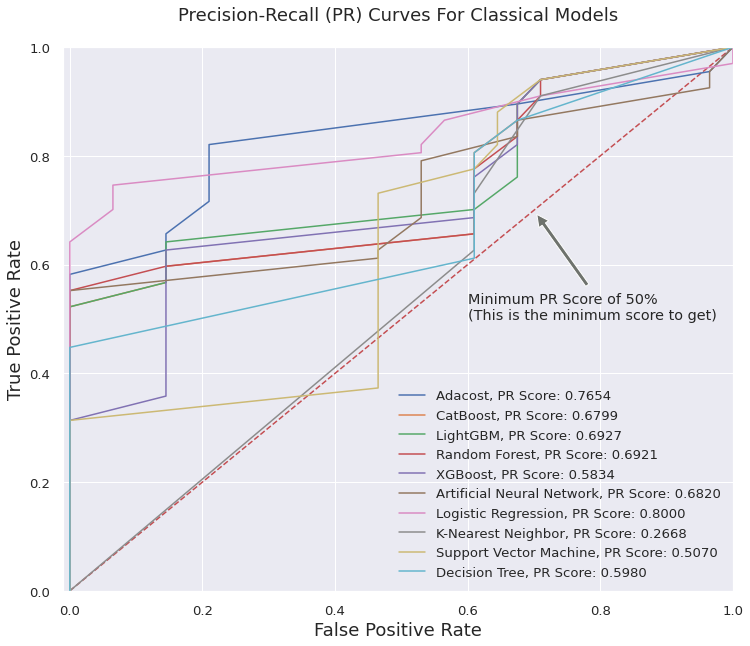

In [159]:
import matplotlib.pyplot as plt 
import seaborn as sns

l_names = ['Adacost','CatBoost','LightGBM','Random Forest','XGBoost',
          'Artificial Neural Network','Logistic Regression','K-Nearest Neighbor','Support Vector Machine',
           'Decision Tree']
y_predprob_test_names = [y_predprob_test_ada,y_predprob_test_cat,y_predprob_test_lgb,y_predprob_test_rf,y_predprob_test_xgb,nn_model_balanced_prediction,y_predprob_test_log,
                        y_predprob_test_knn,y_predprob_test_svm,y_predprob_test_dt]

plt.figure(figsize=(12,10))
plt.plot([0, 1], [0, 1], 'r--')
plt.annotate('Minimum PR Score of 50%\n(This is the minimum score to get)', xy=(0.7, 0.7), xytext=(0.6, 0.5),
            arrowprops=dict(facecolor='#6E726D', shrink=0.05),
            )   

for i, names in enumerate(l_names):
    precision, recall, _ = sklearn.metrics.roc_curve(y_test, y_predprob_test_names[i])
    score = sklearn.metrics.average_precision_score(y_test, y_predprob_test_names[i])
    plt.plot(precision, recall, label='{0}, PR Score: {1:.4f}'.format(l_names[i],score))
    plt.legend()
    
 
plt.title('Precision-Recall (PR) Curves For Classical Models\n', fontsize=18) # Add title to main plot
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.axis([-0.01,1,0,1])
# Save the figure to a file
plt.savefig('PR_6_classical.png')
plt.show()